<a href="https://colab.research.google.com/github/caochengrui/Object_Classification_and_Localiztion/blob/main/Object_Classification_And_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Localization and Classification with TensorFlow

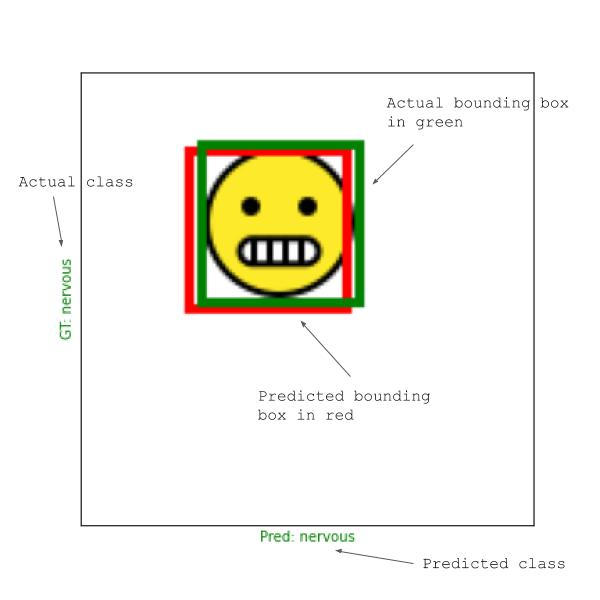

All emojis designed by [OpenMoji](https://openmoji.org/) – the open-source emoji and icon project. License: CC BY-SA 4.0

##  Set Up Environment

In [ ]:
!wget https://github.com/caochengrui/Object_Classification_and_Localiztion/raw/refs/heads/main/requirements.txt
!pip install -r requirements.txt

--2024-12-10 08:25:52--  https://github.com/caochengrui/Object_Classification_and_Localiztion/raw/refs/heads/main/requirements.txt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/caochengrui/Object_Classification_and_Localiztion/refs/heads/main/requirements.txt [following]
--2024-12-10 08:25:52--  https://raw.githubusercontent.com/caochengrui/Object_Classification_and_Localiztion/refs/heads/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]      66  --.-KB/s    in 0s      

2024-12-10

In [ ]:
%matplotlib inline

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
import os

##  Set parameter

In [ ]:
# Set random seed to ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Parameter definitions
IMAGE_SIZE = 144
EMOJI_SIZE = 52
NUM_CLASSES = 9
NUM_SAMPLES = 8000
TRAIN_SPLIT = 0.8

##  Download and Visualize Data

In [ ]:
!wget https://github.com/caochengrui/Object_Classification_and_Localiztion/raw/refs/heads/main/Dataset/openmoji-72x72-color.zip
!mkdir emojis
!unzip -q openmoji-72x72-color.zip -d ./emojis

--2024-12-10 08:26:05--  https://github.com/caochengrui/Object_Classification_and_Localiztion/raw/refs/heads/main/Dataset/openmoji-72x72-color.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/caochengrui/Object_Classification_and_Localiztion/refs/heads/main/Dataset/openmoji-72x72-color.zip [following]
--2024-12-10 08:26:05--  https://raw.githubusercontent.com/caochengrui/Object_Classification_and_Localiztion/refs/heads/main/Dataset/openmoji-72x72-color.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7414997 (7.1M) [application/zip]
Saving to: ‘openmoji-72x72-color.zip’

openmoji-72x72-col

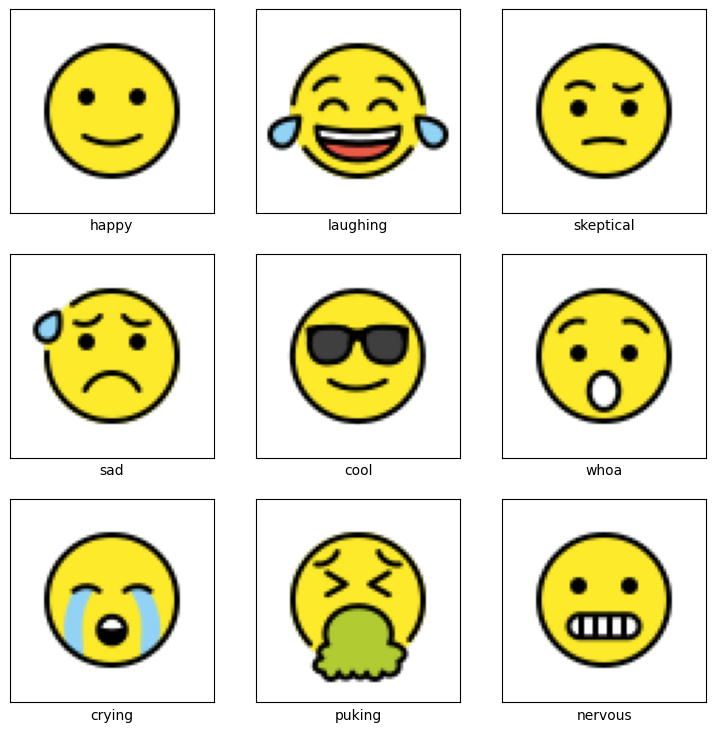

In [ ]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

# Display all emojis with their labels
plt.figure(figsize=(9, 9))
for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

##  Create Examples

In [ ]:
# Convert emoji images to RGB and remove transparent background
for class_id, values in emojis.items():
    # 'A' : alpha channel, which represent the transparency
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    # ensures only parts whose alpha channel is not fully transparent will be pasted
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [ ]:
def create_example():
    class_id = np.random.randint(0, 9)
    # use np.ones() to create white image
    image = np.ones((144, 144, 3), dtype=np.uint8) * 255
    row = np.random.randint(0, 72)
    col = np.random.randint(0, 72)
    image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])

    # The meaningless margin of emoji image is 10 pixels on both sides of row and columns.
    return image, class_id, (row + 10) / 144, (col + 10) / 144

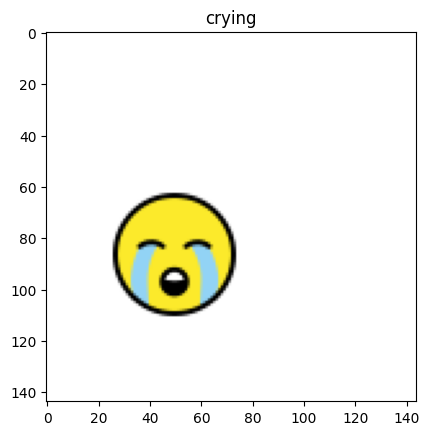

In [ ]:
# Visualize a single example
image, class_id, row, col = create_example()
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

##  Plot Bounding Boxes

In [ ]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
    # If image is PIL Image, conver it to nunpy array to be prepared for normalization
    if isinstance(image, Image.Image):
        image = np.array(image)
    # denormalization of image
    if norm:
        image *= 255.
        image = image.astype('uint8')


    # Convert back to PIL Image for drawing
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)

    # denormalization of bounding box
    row, col = gt_coords
    row *= 144
    col *= 144

    # entire graph size: (144, 144) , emoji image size: (72, 72), actual emoji(cropped): (52, 52)
    draw.rectangle([col, row, col + 52, row + 52], outline='green', width=3)

    if len(pred_coords)==2:
        pred_row, pred_col = pred_coords
        pred_row *= 144
        pred_col *= 144
        draw.rectangle([pred_col, pred_row, pred_col + 52, pred_row + 52], outline='red', width=3)

    return image

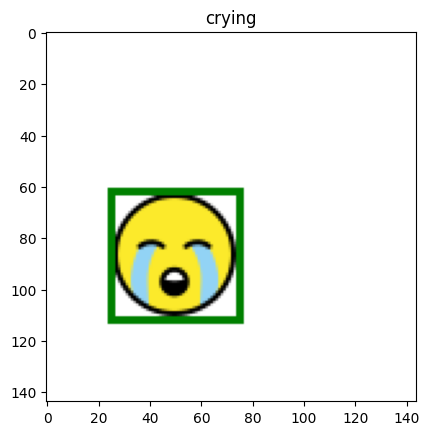

In [ ]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

##  Data Generator

In [ ]:
# Function to generate a dataset including images, class labels, and coordinate labels
def data_generator(num_samples):
    """
    Generate dataset including images, class labels, and coordinate labels.
    """
    images = []
    class_labels = []
    coord_labels = []

    max_position = IMAGE_SIZE - EMOJI_SIZE
    for _ in range(num_samples):
        img, class_label, x, y = create_example()
        images.append(img)
        class_labels.append(class_label)
        coord_labels.append([x, y])

    images = np.array(images, dtype=np.float32) / 255.0 # Normalize to range [0, 1]
    class_labels = np.array(class_labels, dtype=np.int32)
    coord_labels = np.array(coord_labels, dtype=np.float32)

    return images, class_labels, coord_labels

In [ ]:
# Function to display a batch of images with bounding boxes and labels
def display_batch(num_samples=16, dataset=None):
    """
    Display a batch of images with their class names and bounding boxes.

    Parameters:
    - num_samples: Number of images to display in the batch.
    - dataset: Tuple containing images, class labels, and coordinate labels.
               If not provided, a new dataset will be generated.
    """
    # Calculate grid size for subplots
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    plt.figure(figsize=(grid_size * 3, grid_size * 3))

    for i in range(num_samples):
        # Extract the image, class label, and coordinates
        image = images[i] * 255  # Rescale to [0, 255]
        image = image.astype('uint8')  # Convert to uint8
        class_id = class_labels[i]
        coord = coord_labels[i]

        # Plot bounding box on the image
        image_with_box = plot_bounding_box(image, gt_coords=coord)

        # Display the image in a subplot
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(image_with_box)
        plt.title(emojis[class_id]['name'])

    plt.tight_layout()
    plt.show()

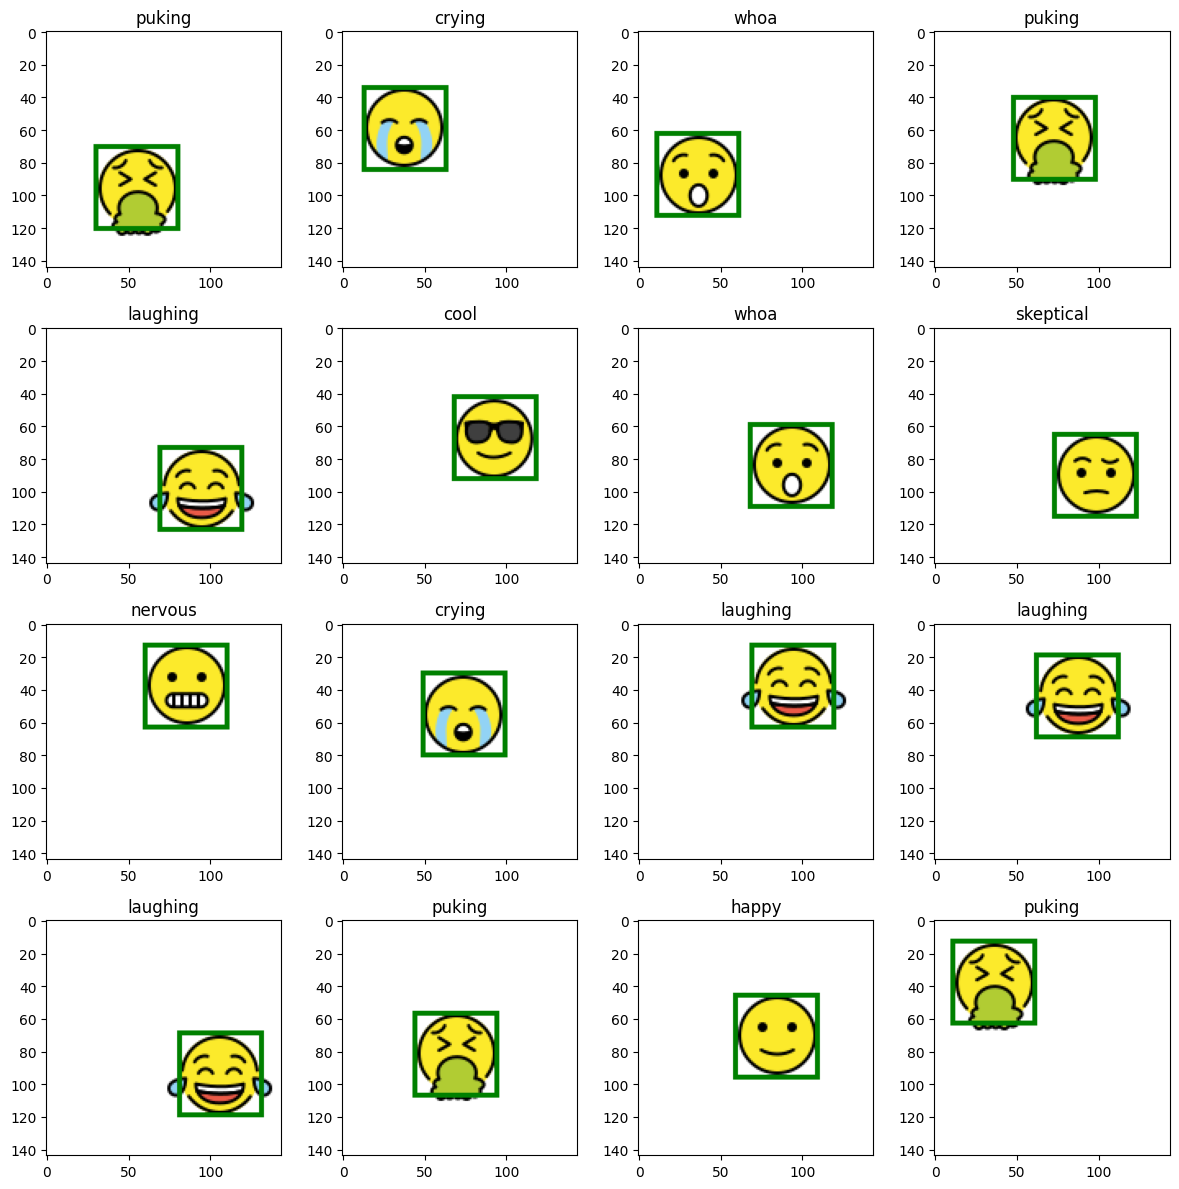

In [ ]:
# Call the function to display a batch of images
images, class_labels, coord_labels = data_generator(16)
display_batch(16, dataset=(images, class_labels, coord_labels))

# Generate the dataset
images, class_labels, coord_labels = data_generator(NUM_SAMPLES)

c

In [ ]:
# Split into training and testing datasets
split_idx = int(NUM_SAMPLES * TRAIN_SPLIT)
x_train, x_test = images[:split_idx], images[split_idx:]
y_train_class, y_test_class = class_labels[:split_idx], class_labels[split_idx:]
y_train_coord, y_test_coord = coord_labels[:split_idx], coord_labels[split_idx:]

# Convert class labels to one-hot encoding
y_train_class = keras.utils.to_categorical(y_train_class, NUM_CLASSES)
y_test_class = keras.utils.to_categorical(y_test_class, NUM_CLASSES)

##  Custom Metric: IoU(Intersection over Union)

In [ ]:
import tensorflow as tf

class IoU(tf.keras.metrics.Metric):
    def __init__(self, name='iou', **kwargs):
        super(IoU, self).__init__(name=name, **kwargs)
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            # y: (batch_size, 2) -> (row, col)
            # 转换为像素坐标
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 144, cols * 144
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            return x1, y1, x2, y2

        def safe_area(x1, y1, x2, y2):
            w = tf.maximum(0.0, x2 - x1)
            h = tf.maximum(0.0, y2 - y1)
            return w * h

        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

        # 求交集框坐标
        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)

        # 计算交集、并集面积
        i_area = safe_area(i_x1, i_y1, i_x2, i_y2)
        gt_area = safe_area(gt_x1, gt_y1, gt_x2, gt_y2)
        p_area = safe_area(p_x1, p_y1, p_x2, p_y2)
        u_area = gt_area + p_area - i_area

        # 避免除以0
        iou = tf.where(tf.equal(u_area, 0.0), tf.zeros_like(u_area), i_area / u_area)

        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))

    def result(self):
        # 使用 no_nan 避免除0
        return tf.math.divide_no_nan(self.total_iou, self.num_ex)

    def reset_state(self):
        self.total_iou.assign(0.0)
        self.num_ex.assign(0.0)


##  Model

In [ ]:
# Input layer
input_layer = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='image')

# Convolution + BN + Pooling layers (5 sets)
x = layers.Conv2D(16, (3,3), activation='relu', padding='valid')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='valid')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(256, (3,3), activation='relu', padding='valid')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

# Flatten + Fully-connected layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)

# Output layers
class_output = layers.Dense(NUM_CLASSES, activation='softmax', name='class_output')(x)
coord_output = layers.Dense(2, activation='sigmoid', name='coord_output')(x)

# Define the model
model = models.Model(inputs=input_layer, outputs=[class_output, coord_output])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 144, 144, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 142, 142, 16)   │            448 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 142, 142, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 71, 71, 16)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 69, 69, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 69, 69, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 34, 34, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 14, 14, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 7, 7, 128)      │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 5, 5, 256)      │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 5, 5, 256)      │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 659,819 (2.52 MB)

 Trainable params: 658,827 (2.51 MB)

 Non-trainable params: 992 (3.88 KB)

##  Compile the Model

In [ ]:
model.compile(
    optimizer=optimizers.Adam(),
    loss={
        'class_output': 'categorical_crossentropy',
        'coord_output': 'mse'
    },
    metrics={
        'class_output': 'accuracy',
        'coord_output': IoU(name='iou')
    }
)

##  Custom Callback

In [ ]:
# Visualization callback class after model and dataset definition
class VisualizationCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_data, y_class, y_coord, emojis, batch_size=8):
        super().__init__()
        self.x_data = x_data
        self.y_class = y_class
        self.y_coord = y_coord
        self.batch_size = batch_size
        self.emojis = emojis

    def on_epoch_end(self, epoch, logs=None):
        # Select a batch of data to visualize
        idx = np.random.randint(0, self.x_data.shape[0], self.batch_size)
        x_batch = self.x_data[idx]
        y_class_batch = self.y_class[idx]
        y_coord_batch = self.y_coord[idx]

        # Model prediction
        class_preds, coord_preds = self.model.predict(x_batch, verbose=0)
        class_pred_labels = np.argmax(class_preds, axis=1)

        # Visualization
        fig, axs = plt.subplots(1, self.batch_size, figsize=(4*self.batch_size, 4))

        for i in range(self.batch_size):
            ax = axs[i]  # Only one row, so directly use axs[i]
            img = (x_batch[i] * 255).astype('uint8')
            true_class_id = np.argmax(y_class_batch[i])
            true_coord = y_coord_batch[i]
            pred_class_id = class_pred_labels[i]
            pred_coord = coord_preds[i]

            img_with_box = plot_bounding_box(img, gt_coords=true_coord, pred_coords=pred_coord, norm=False)
            title_str = f"T: {self.emojis[true_class_id]['name']}\nP: {self.emojis[pred_class_id]['name']}"
            ax.imshow(img_with_box)
            ax.set_title(title_str, fontsize=10)
            ax.axis('off')

        plt.suptitle(f"Epoch {epoch+1} Visualization")
        plt.tight_layout()
        plt.show()

# Add callback after the data and model have been defined
vis_callback = VisualizationCallback(
    x_data=x_test,
    y_class=y_test_class,
    y_coord=y_test_coord,
    emojis=emojis,
    batch_size=4  # Adjust batch size as needed
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_coord_output_iou',  # Can be adjusted to monitor IoU, val_loss, etc.
    factor=0.5,                      # Factor by which to reduce the learning rate
    patience=3,                      # If no improvement after 3 epochs, reduce LR
    verbose=1,                       # Print logs
    min_lr=1e-6                      # Lower bound on learning rate
)

early_stop = EarlyStopping(
    monitor='val_coord_output_iou',  # Choose the metric to monitor
    mode='max',
    patience=4,                      # Stop if no improvement after 4 epochs
    restore_best_weights=True,       # Restore weights from the epoch with the best validation metric
    verbose=1
)

##  Model Training

Epoch 1/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - class_output_accuracy: 0.6140 - class_output_loss: 1.2932 - coord_output_iou: 0.3531 - coord_output_loss: 0.0314 - loss: 1.3246

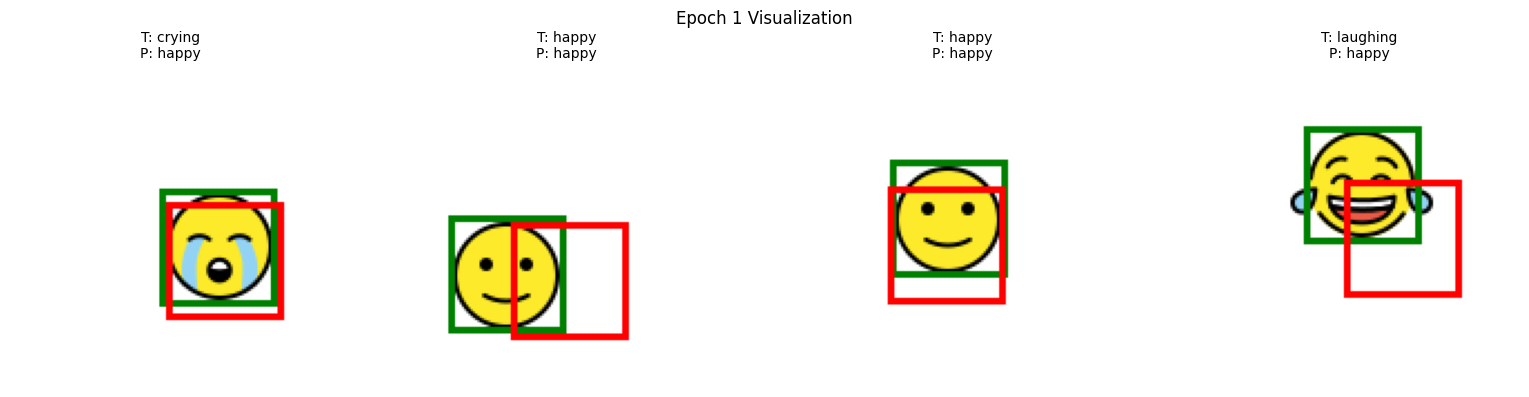

400/400 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - class_output_accuracy: 0.6164 - class_output_loss: 1.2851 - coord_output_iou: 0.3540 - coord_output_loss: 0.0312 - loss: 1.3163 - val_class_output_accuracy: 0.2013 - val_class_output_loss: 6.9543 - val_coord_output_iou: 0.3006 - val_coord_output_loss: 0.0272 - val_loss: 6.9815 - learning_rate: 0.0010
Epoch 2/50
395/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 0.9984 - class_output_loss: 0.0074 - coord_output_iou: 0.5794 - coord_output_loss: 0.0051 - loss: 0.0125

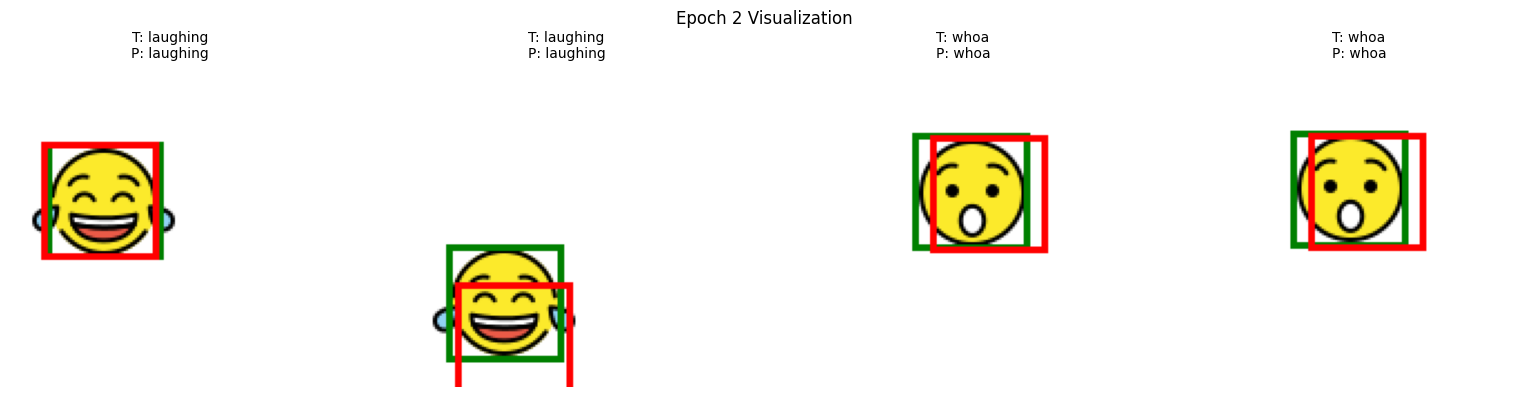

400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - class_output_accuracy: 0.9984 - class_output_loss: 0.0073 - coord_output_iou: 0.5800 - coord_output_loss: 0.0051 - loss: 0.0124 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 7.5978e-04 - val_coord_output_iou: 0.6654 - val_coord_output_loss: 0.0027 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 3/50
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.3036e-04 - coord_output_iou: 0.7022 - coord_output_loss: 0.0020 - loss: 0.0023

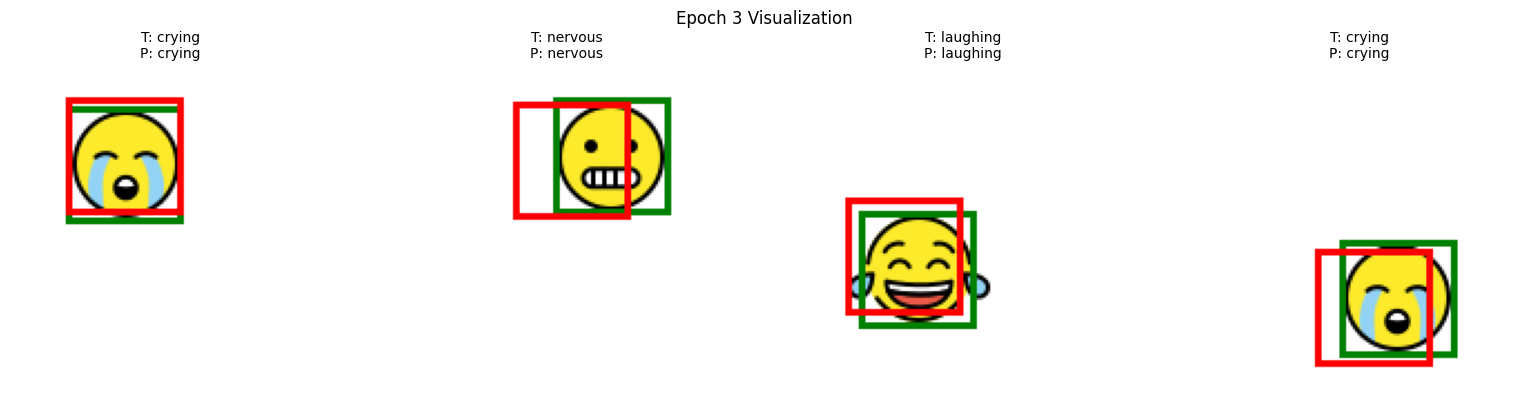

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.3002e-04 - coord_output_iou: 0.7024 - coord_output_loss: 0.0020 - loss: 0.0023 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 6.0023e-04 - val_coord_output_iou: 0.7016 - val_coord_output_loss: 0.0020 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 4/50
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.7725e-04 - coord_output_iou: 0.7769 - coord_output_loss: 9.3551e-04 - loss: 0.0011

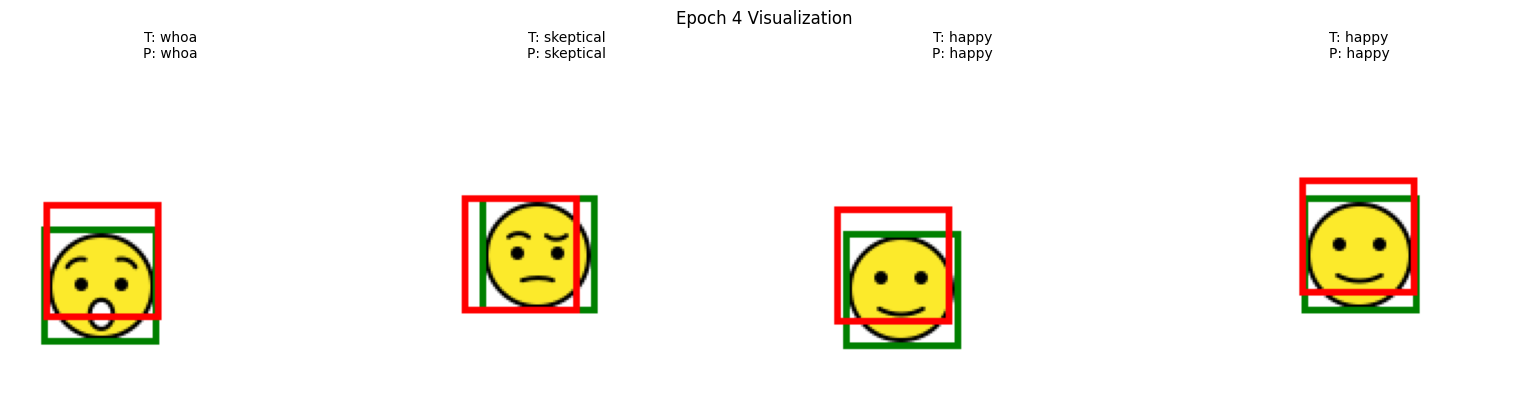


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.7718e-04 - coord_output_iou: 0.7769 - coord_output_loss: 9.3470e-04 - loss: 0.0011 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.7342e-04 - val_coord_output_iou: 0.7466 - val_coord_output_loss: 0.0013 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.2796e-04 - coord_output_iou: 0.8116 - coord_output_loss: 6.3436e-04 - loss: 7.6233e-04

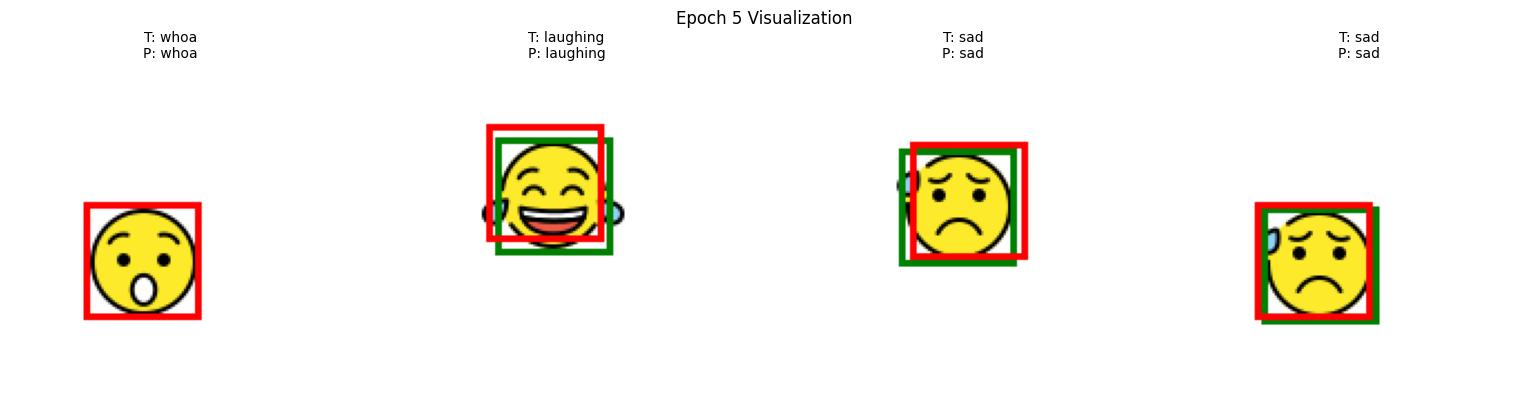

400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.2793e-04 - coord_output_iou: 0.8117 - coord_output_loss: 6.3400e-04 - loss: 7.6193e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 1.2463e-04 - val_coord_output_iou: 0.7779 - val_coord_output_loss: 9.2464e-04 - val_loss: 0.0010 - learning_rate: 5.0000e-04
Epoch 6/50
395/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.0821e-04 - coord_output_iou: 0.8290 - coord_output_loss: 5.0647e-04 - loss: 6.1468e-04

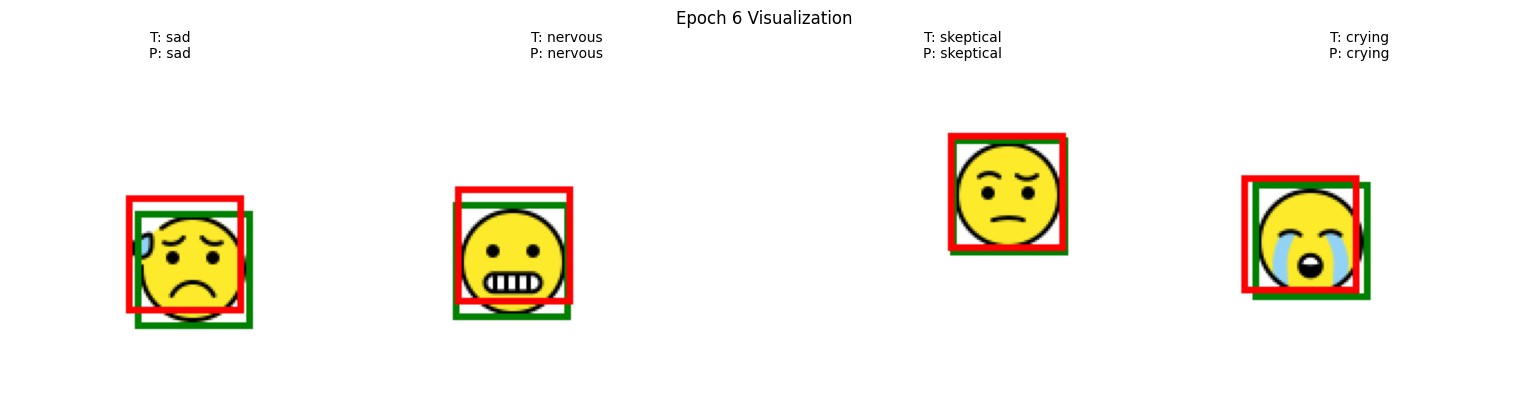

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.0817e-04 - coord_output_iou: 0.8291 - coord_output_loss: 5.0572e-04 - loss: 6.1390e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 1.1520e-04 - val_coord_output_iou: 0.7807 - val_coord_output_loss: 8.9285e-04 - val_loss: 0.0010 - learning_rate: 5.0000e-04
Epoch 7/50
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 9.1059e-05 - coord_output_iou: 0.8468 - coord_output_loss: 3.9156e-04 - loss: 4.8262e-04

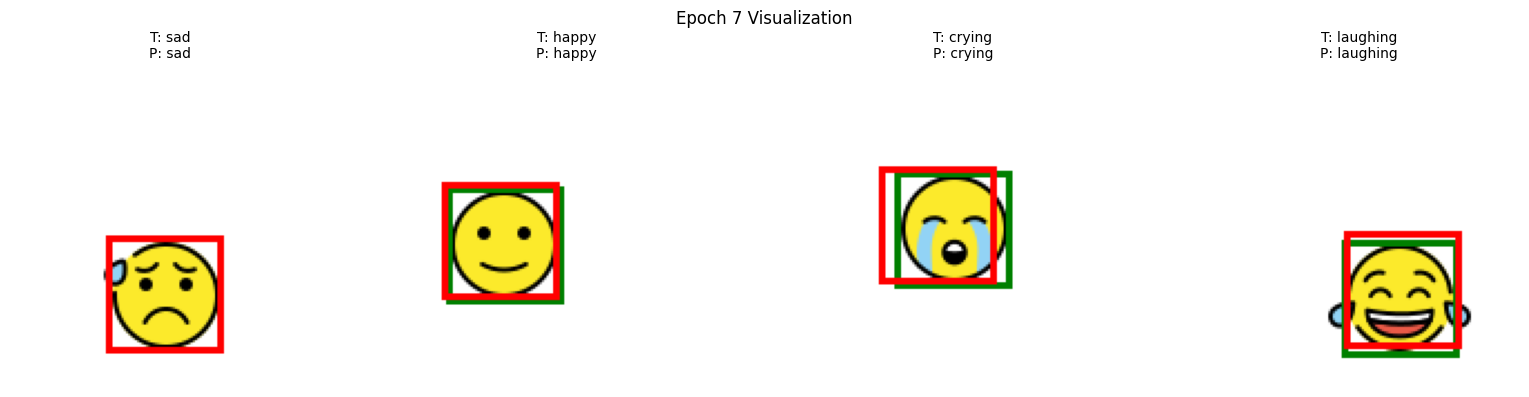


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - class_output_accuracy: 1.0000 - class_output_loss: 9.1042e-05 - coord_output_iou: 0.8468 - coord_output_loss: 3.9128e-04 - loss: 4.8233e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 1.0374e-04 - val_coord_output_iou: 0.7859 - val_coord_output_loss: 8.4162e-04 - val_loss: 9.4535e-04 - learning_rate: 5.0000e-04
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 7.7604e-05 - coord_output_iou: 0.8491 - coord_output_loss: 3.8290e-04 - loss: 4.6050e-04

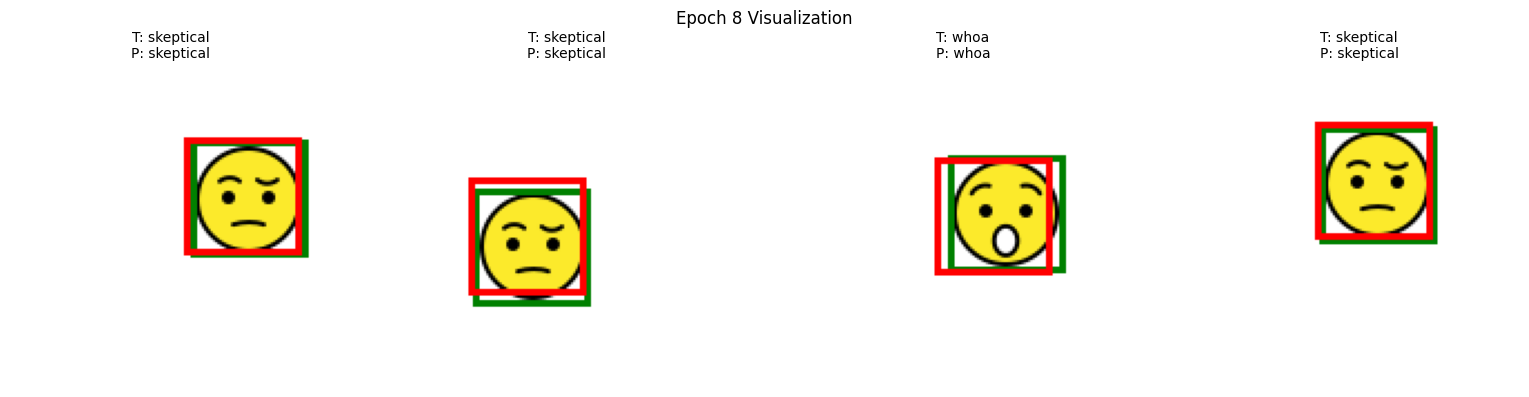

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - class_output_accuracy: 1.0000 - class_output_loss: 7.7602e-05 - coord_output_iou: 0.8491 - coord_output_loss: 3.8284e-04 - loss: 4.6045e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 8.1225e-05 - val_coord_output_iou: 0.7902 - val_coord_output_loss: 7.9967e-04 - val_loss: 8.8089e-04 - learning_rate: 2.5000e-04
Epoch 9/50
395/400 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - class_output_accuracy: 1.0000 - class_output_loss: 7.0613e-05 - coord_output_iou: 0.8553 - coord_output_loss: 3.4859e-04 - loss: 4.1921e-04

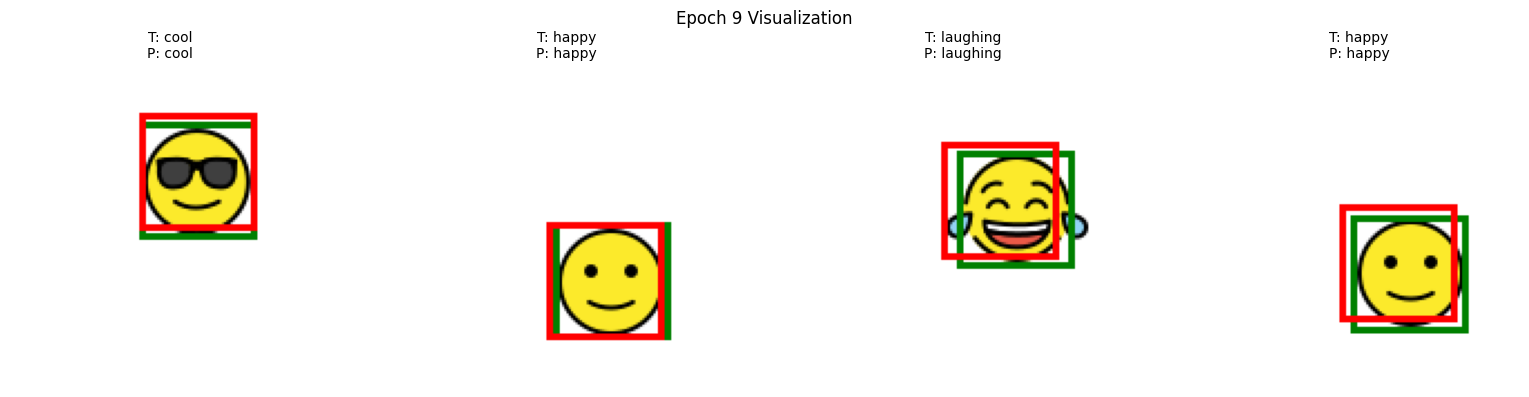

400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - class_output_accuracy: 1.0000 - class_output_loss: 7.0596e-05 - coord_output_iou: 0.8554 - coord_output_loss: 3.4791e-04 - loss: 4.1851e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 7.3253e-05 - val_coord_output_iou: 0.7950 - val_coord_output_loss: 7.6040e-04 - val_loss: 8.3365e-04 - learning_rate: 2.5000e-04
Epoch 10/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 6.3478e-05 - coord_output_iou: 0.8677 - coord_output_loss: 2.8304e-04 - loss: 3.4652e-04

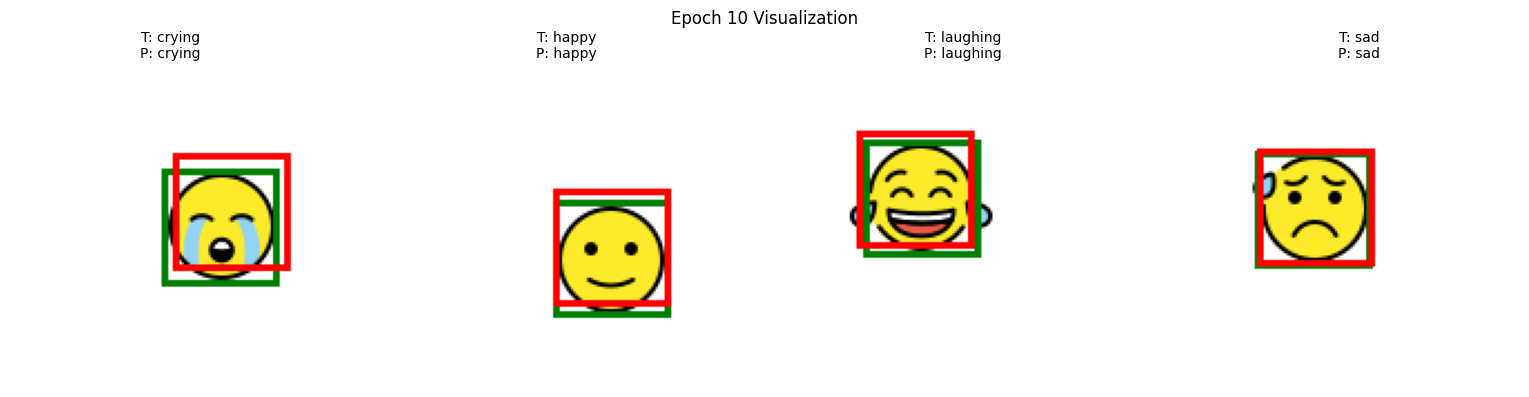


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 6.3467e-05 - coord_output_iou: 0.8677 - coord_output_loss: 2.8271e-04 - loss: 3.4618e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 6.7380e-05 - val_coord_output_iou: 0.7989 - val_coord_output_loss: 7.3036e-04 - val_loss: 7.9774e-04 - learning_rate: 2.5000e-04
Epoch 11/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 5.6841e-05 - coord_output_iou: 0.8711 - coord_output_loss: 2.6722e-04 - loss: 3.2406e-04

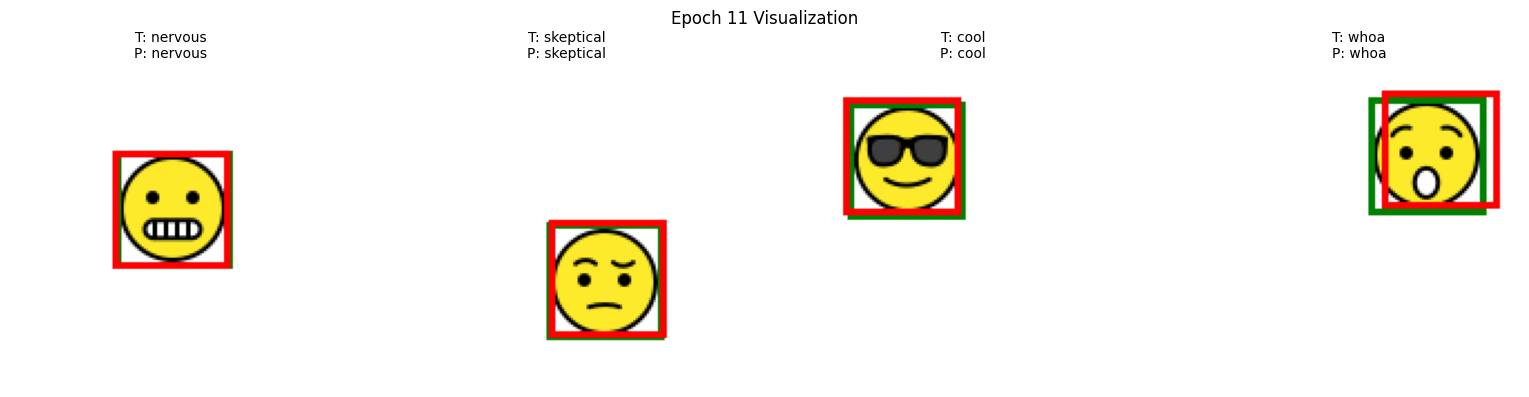

400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 5.6835e-05 - coord_output_iou: 0.8712 - coord_output_loss: 2.6695e-04 - loss: 3.2379e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 5.5983e-05 - val_coord_output_iou: 0.8260 - val_coord_output_loss: 5.2657e-04 - val_loss: 5.8255e-04 - learning_rate: 1.2500e-04
Epoch 12/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 5.3253e-05 - coord_output_iou: 0.8816 - coord_output_loss: 2.2065e-04 - loss: 2.7390e-04

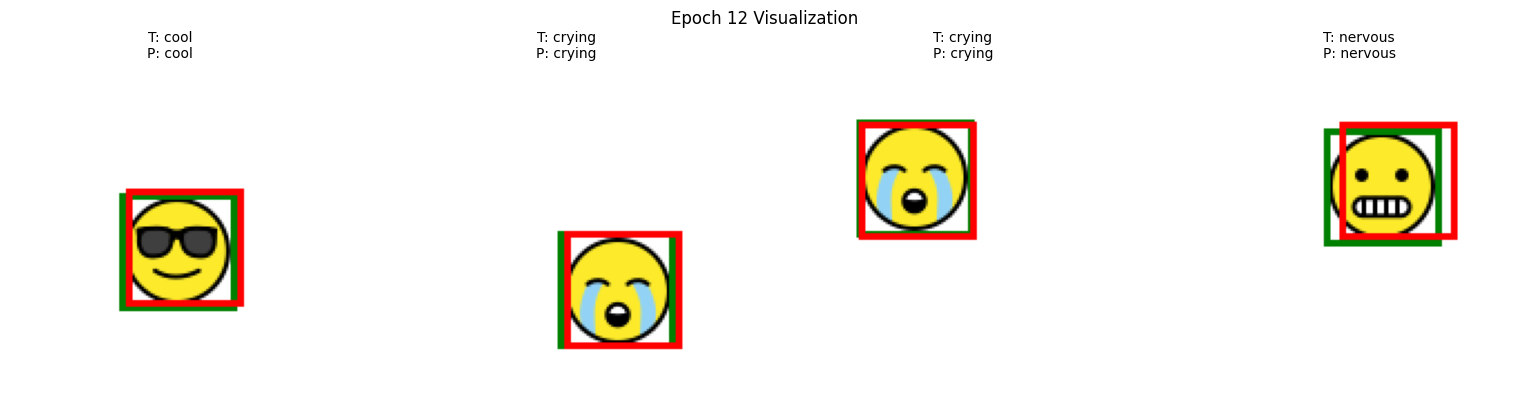

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - class_output_accuracy: 1.0000 - class_output_loss: 5.3251e-05 - coord_output_iou: 0.8816 - coord_output_loss: 2.2060e-04 - loss: 2.7385e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 5.4541e-05 - val_coord_output_iou: 0.8285 - val_coord_output_loss: 5.0998e-04 - val_loss: 5.6452e-04 - learning_rate: 1.2500e-04
Epoch 13/50
396/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 4.9285e-05 - coord_output_iou: 0.8896 - coord_output_loss: 1.8879e-04 - loss: 2.3807e-04

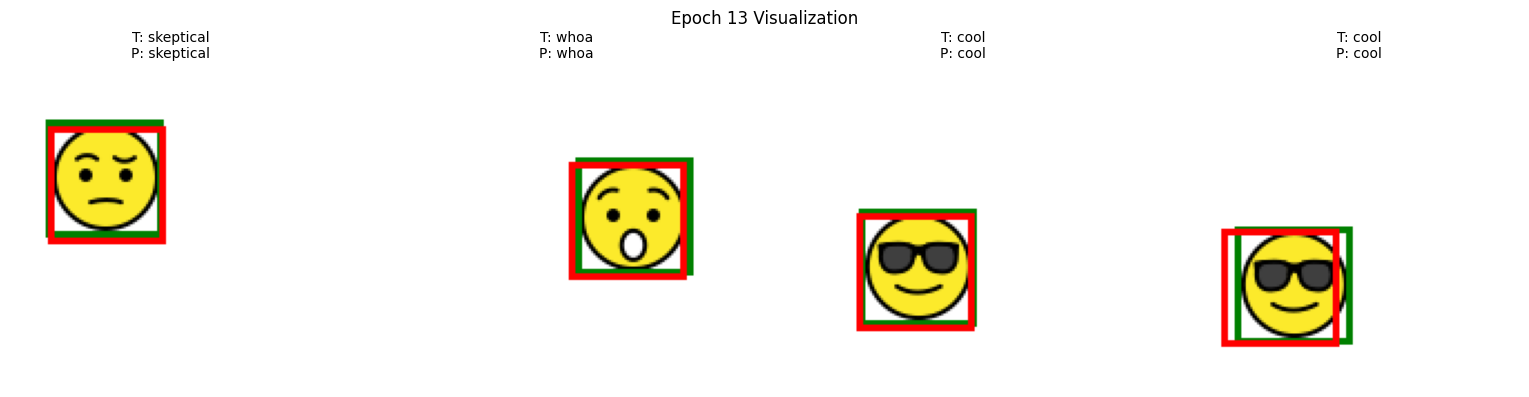


Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 4.9275e-05 - coord_output_iou: 0.8897 - coord_output_loss: 1.8860e-04 - loss: 2.3787e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 5.1756e-05 - val_coord_output_iou: 0.8316 - val_coord_output_loss: 4.9177e-04 - val_loss: 5.4353e-04 - learning_rate: 1.2500e-04
Epoch 14/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 4.5457e-05 - coord_output_iou: 0.8939 - coord_output_loss: 1.7275e-04 - loss: 2.1821e-04

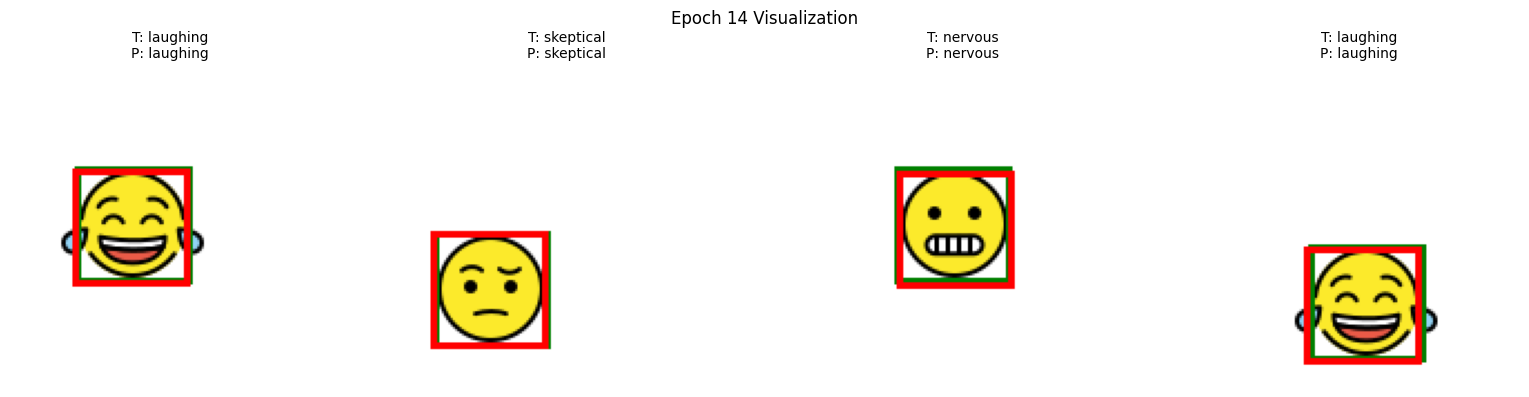

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - class_output_accuracy: 1.0000 - class_output_loss: 4.5456e-05 - coord_output_iou: 0.8940 - coord_output_loss: 1.7273e-04 - loss: 2.1819e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 4.7893e-05 - val_coord_output_iou: 0.8340 - val_coord_output_loss: 4.8261e-04 - val_loss: 5.3050e-04 - learning_rate: 6.2500e-05
Epoch 15/50
396/400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - class_output_accuracy: 1.0000 - class_output_loss: 4.3308e-05 - coord_output_iou: 0.8992 - coord_output_loss: 1.5442e-04 - loss: 1.9773e-04

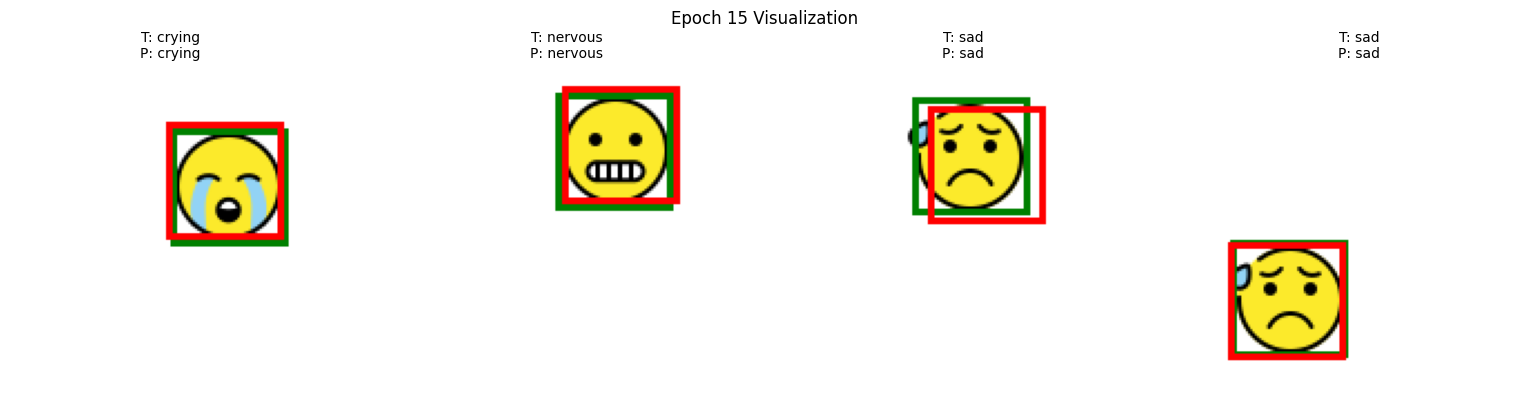

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - class_output_accuracy: 1.0000 - class_output_loss: 4.3301e-05 - coord_output_iou: 0.8992 - coord_output_loss: 1.5431e-04 - loss: 1.9762e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 4.6720e-05 - val_coord_output_iou: 0.8352 - val_coord_output_loss: 4.7296e-04 - val_loss: 5.1968e-04 - learning_rate: 6.2500e-05
Epoch 16/50
396/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 4.0888e-05 - coord_output_iou: 0.9045 - coord_output_loss: 1.3751e-04 - loss: 1.7840e-04

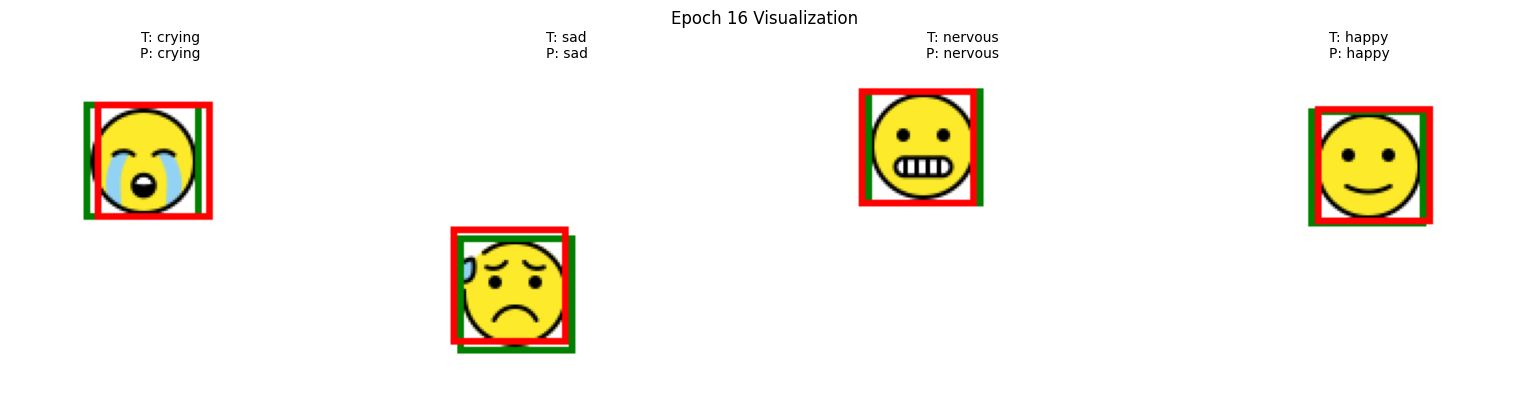


Epoch 16: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - class_output_accuracy: 1.0000 - class_output_loss: 4.0879e-05 - coord_output_iou: 0.9045 - coord_output_loss: 1.3742e-04 - loss: 1.7830e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 4.4250e-05 - val_coord_output_iou: 0.8359 - val_coord_output_loss: 4.6737e-04 - val_loss: 5.1162e-04 - learning_rate: 6.2500e-05
Epoch 17/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.8476e-05 - coord_output_iou: 0.9075 - coord_output_loss: 1.2739e-04 - loss: 1.6587e-04

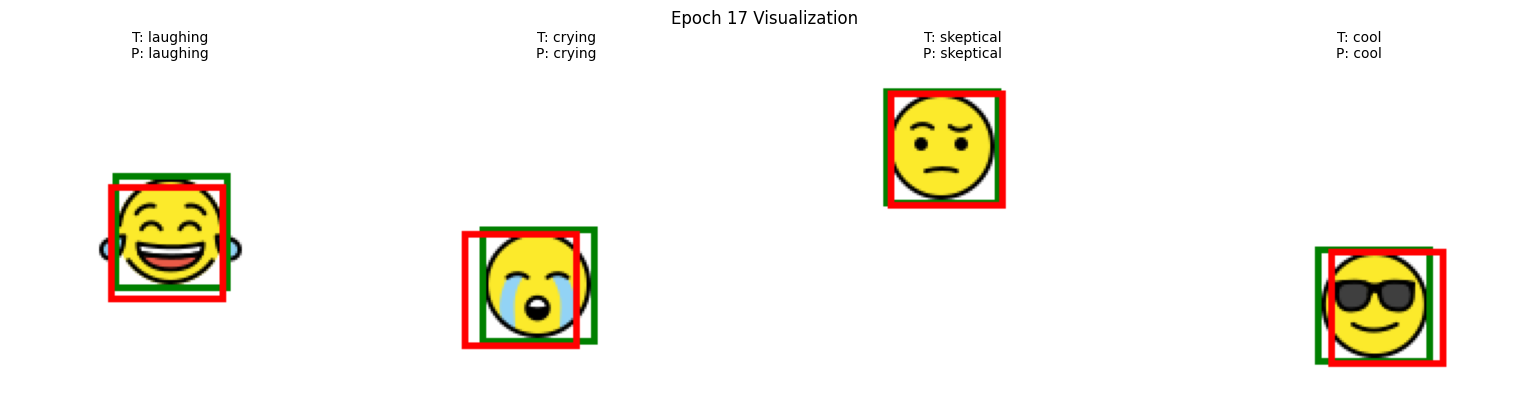

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.8472e-05 - coord_output_iou: 0.9076 - coord_output_loss: 1.2736e-04 - loss: 1.6583e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 4.4242e-05 - val_coord_output_iou: 0.8411 - val_coord_output_loss: 4.4093e-04 - val_loss: 4.8517e-04 - learning_rate: 3.1250e-05
Epoch 18/50
396/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.7074e-05 - coord_output_iou: 0.9107 - coord_output_loss: 1.1812e-04 - loss: 1.5520e-04

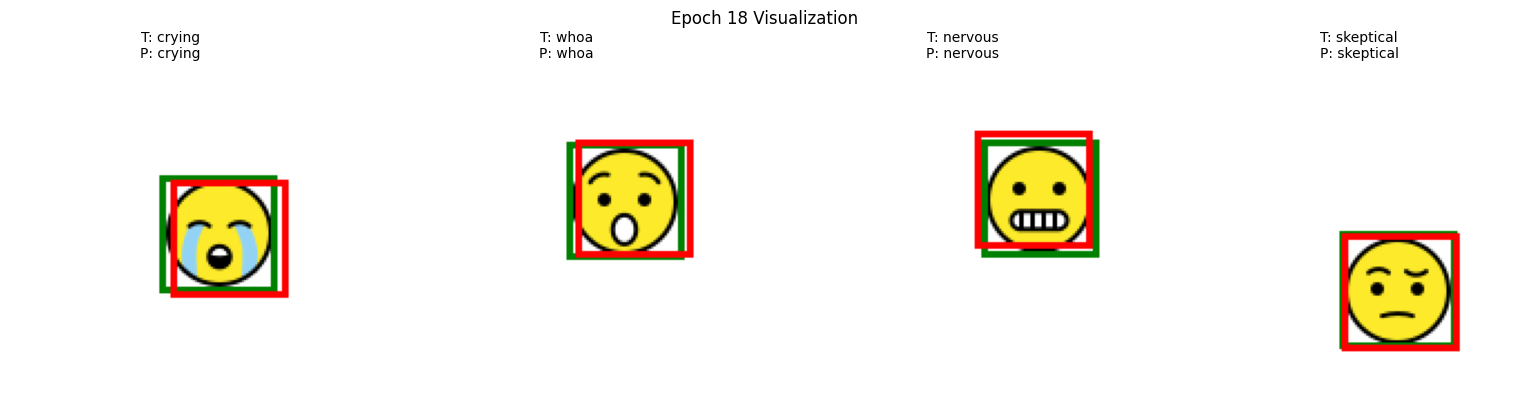

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.7067e-05 - coord_output_iou: 0.9108 - coord_output_loss: 1.1806e-04 - loss: 1.5513e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 4.2700e-05 - val_coord_output_iou: 0.8405 - val_coord_output_loss: 4.4230e-04 - val_loss: 4.8500e-04 - learning_rate: 3.1250e-05
Epoch 19/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.5430e-05 - coord_output_iou: 0.9144 - coord_output_loss: 1.0806e-04 - loss: 1.4349e-04

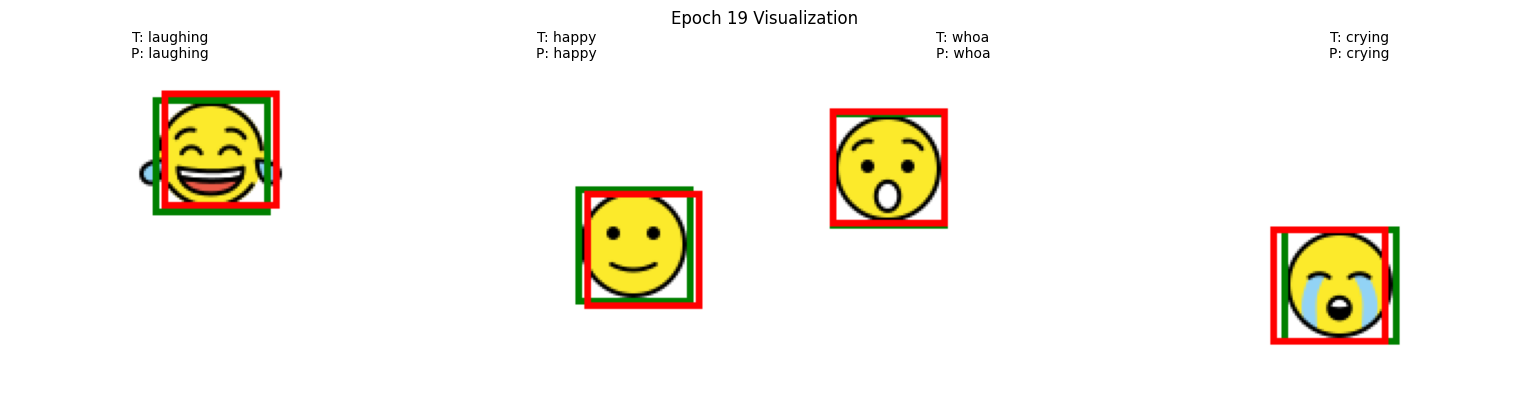


Epoch 19: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.5429e-05 - coord_output_iou: 0.9144 - coord_output_loss: 1.0805e-04 - loss: 1.4348e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 4.0805e-05 - val_coord_output_iou: 0.8399 - val_coord_output_loss: 4.4432e-04 - val_loss: 4.8513e-04 - learning_rate: 3.1250e-05
Epoch 20/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.3790e-05 - coord_output_iou: 0.9160 - coord_output_loss: 1.0350e-04 - loss: 1.3729e-04

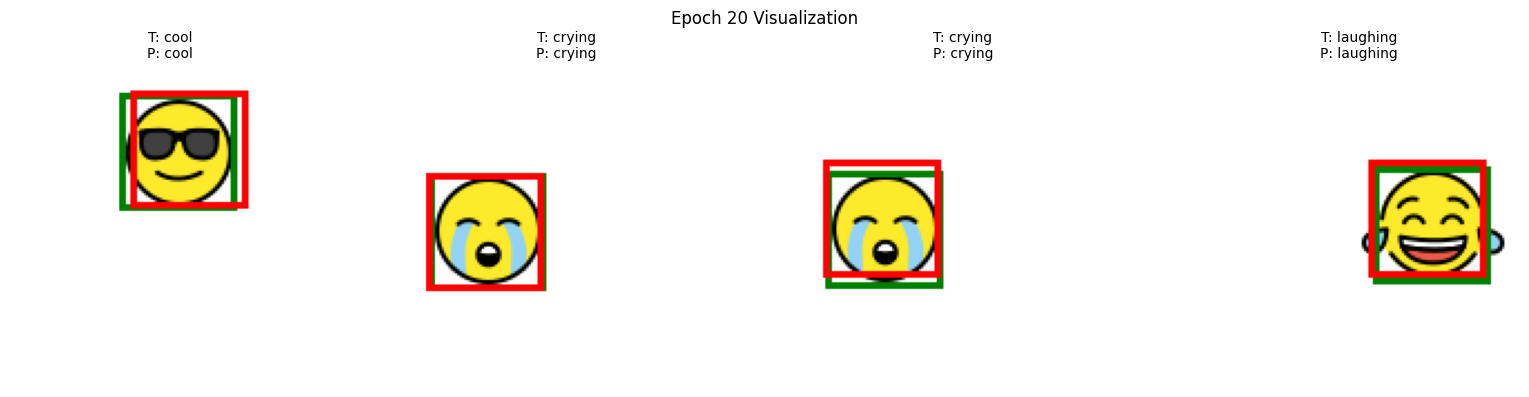

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.3785e-05 - coord_output_iou: 0.9160 - coord_output_loss: 1.0349e-04 - loss: 1.3727e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 4.0975e-05 - val_coord_output_iou: 0.8502 - val_coord_output_loss: 3.8672e-04 - val_loss: 4.2770e-04 - learning_rate: 1.5625e-05
Epoch 21/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.2742e-05 - coord_output_iou: 0.9190 - coord_output_loss: 9.5776e-05 - loss: 1.2852e-04

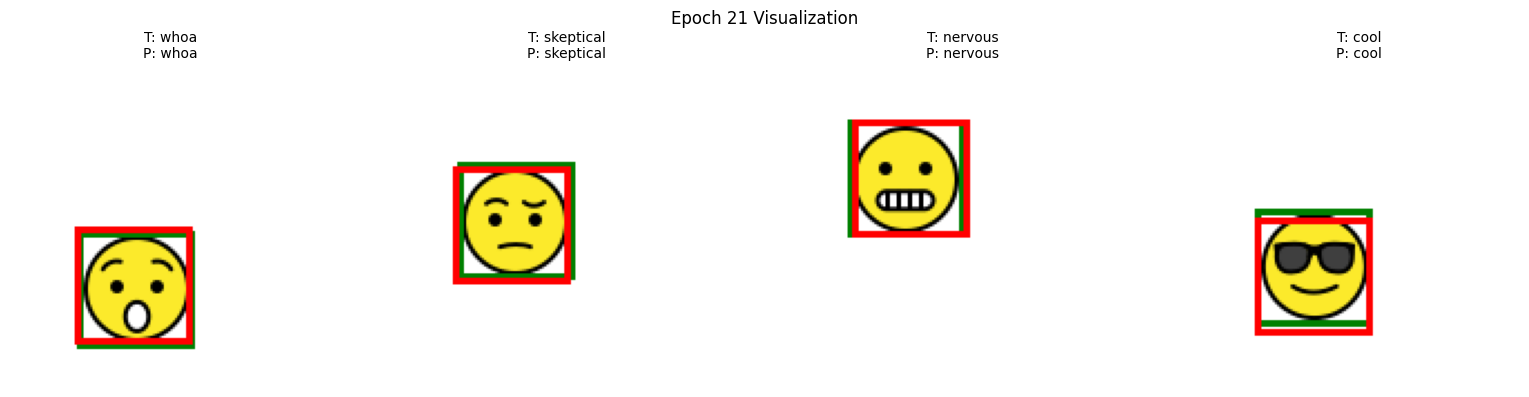

400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.2741e-05 - coord_output_iou: 0.9190 - coord_output_loss: 9.5772e-05 - loss: 1.2851e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.9304e-05 - val_coord_output_iou: 0.8496 - val_coord_output_loss: 3.8871e-04 - val_loss: 4.2802e-04 - learning_rate: 1.5625e-05
Epoch 22/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.1611e-05 - coord_output_iou: 0.9217 - coord_output_loss: 8.9444e-05 - loss: 1.2105e-04

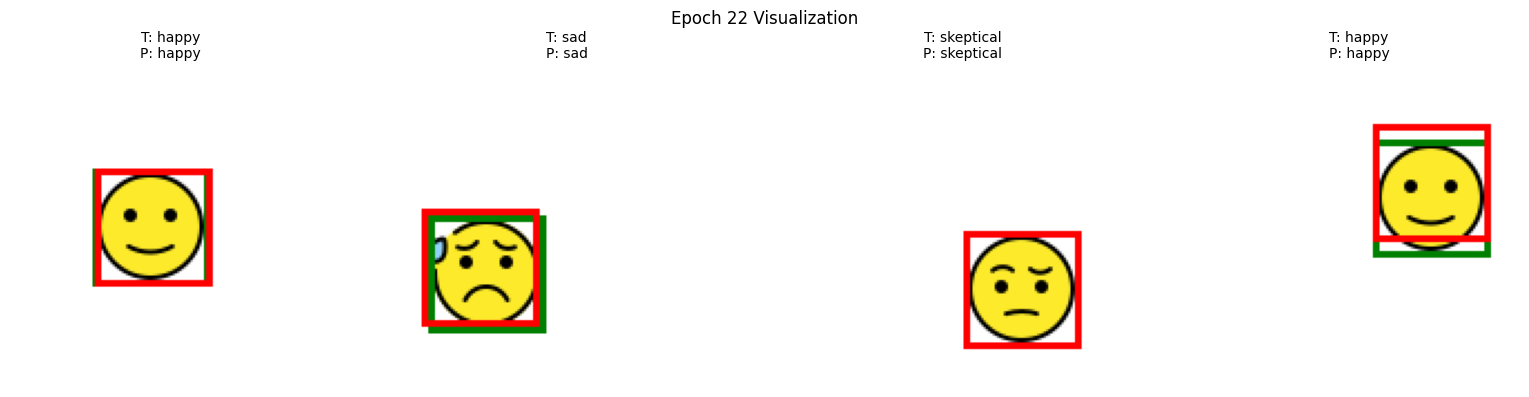


Epoch 22: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.1606e-05 - coord_output_iou: 0.9217 - coord_output_loss: 8.9424e-05 - loss: 1.2103e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.7539e-05 - val_coord_output_iou: 0.8487 - val_coord_output_loss: 3.9276e-04 - val_loss: 4.3030e-04 - learning_rate: 1.5625e-05
Epoch 23/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.0427e-05 - coord_output_iou: 0.9225 - coord_output_loss: 8.7041e-05 - loss: 1.1747e-04

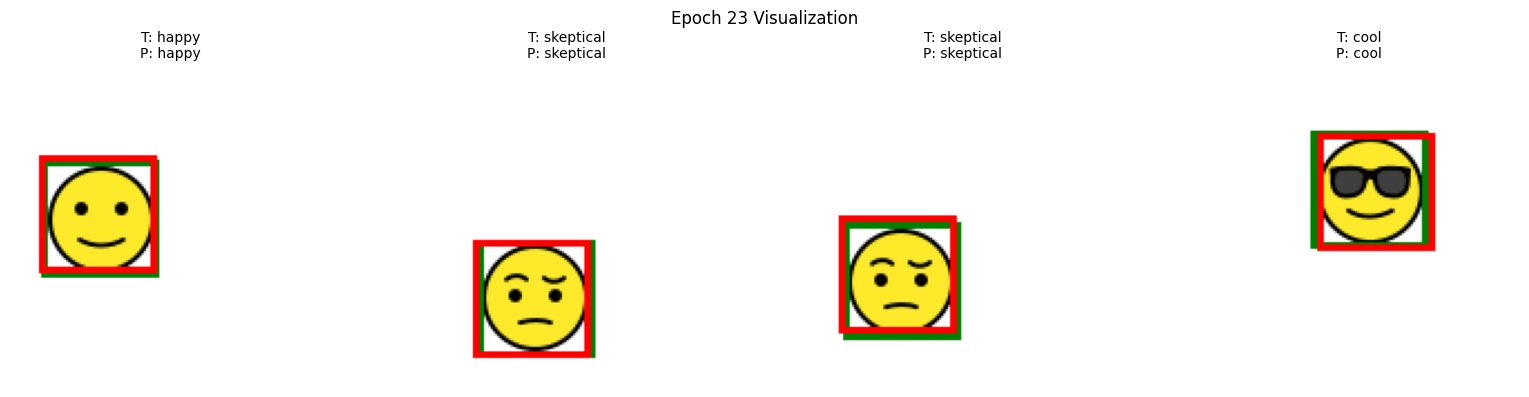

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - class_output_accuracy: 1.0000 - class_output_loss: 3.0423e-05 - coord_output_iou: 0.9225 - coord_output_loss: 8.7030e-05 - loss: 1.1745e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.7611e-05 - val_coord_output_iou: 0.8516 - val_coord_output_loss: 3.8275e-04 - val_loss: 4.2036e-04 - learning_rate: 7.8125e-06
Epoch 24/50
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.9648e-05 - coord_output_iou: 0.9248 - coord_output_loss: 8.2355e-05 - loss: 1.1200e-04

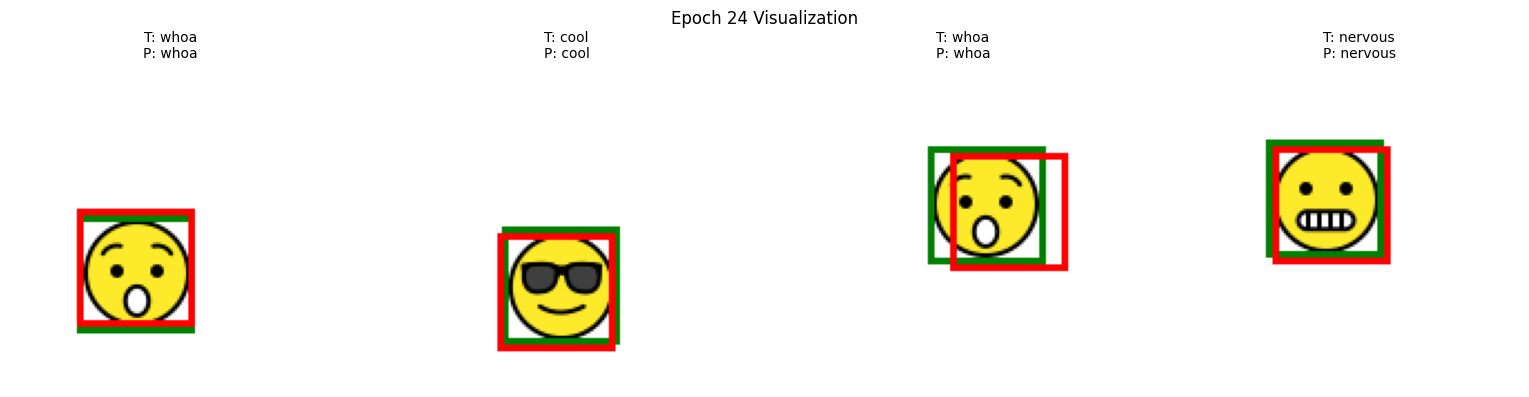

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.9645e-05 - coord_output_iou: 0.9248 - coord_output_loss: 8.2344e-05 - loss: 1.1199e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.6768e-05 - val_coord_output_iou: 0.8519 - val_coord_output_loss: 3.7930e-04 - val_loss: 4.1607e-04 - learning_rate: 7.8125e-06
Epoch 25/50
396/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.8826e-05 - coord_output_iou: 0.9269 - coord_output_loss: 7.7800e-05 - loss: 1.0663e-04

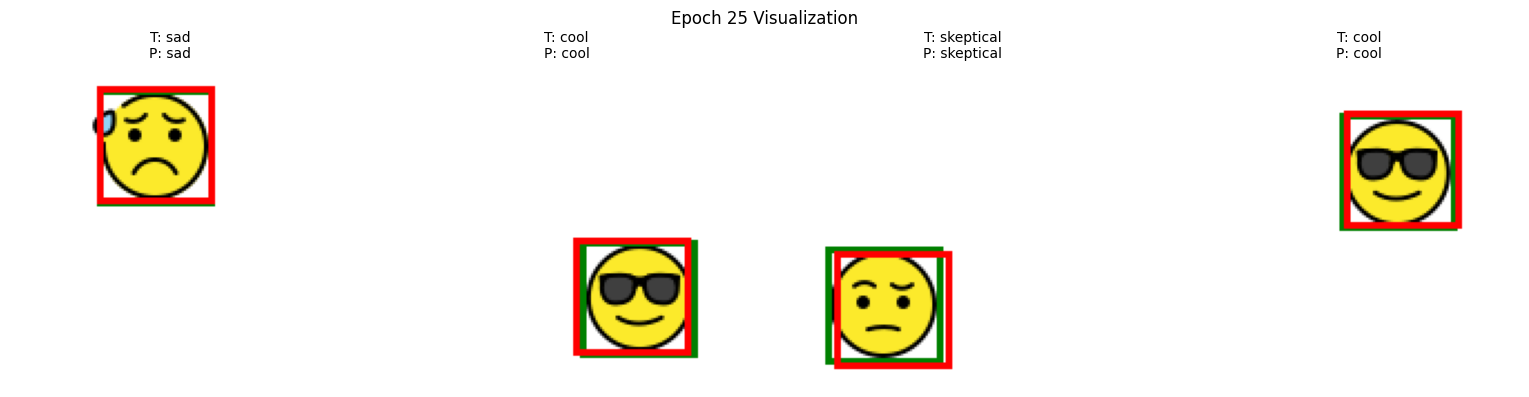


Epoch 25: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.8821e-05 - coord_output_iou: 0.9269 - coord_output_loss: 7.7781e-05 - loss: 1.0660e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.5981e-05 - val_coord_output_iou: 0.8523 - val_coord_output_loss: 3.7613e-04 - val_loss: 4.1211e-04 - learning_rate: 7.8125e-06
Epoch 26/50
396/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.7982e-05 - coord_output_iou: 0.9277 - coord_output_loss: 7.5830e-05 - loss: 1.0381e-04

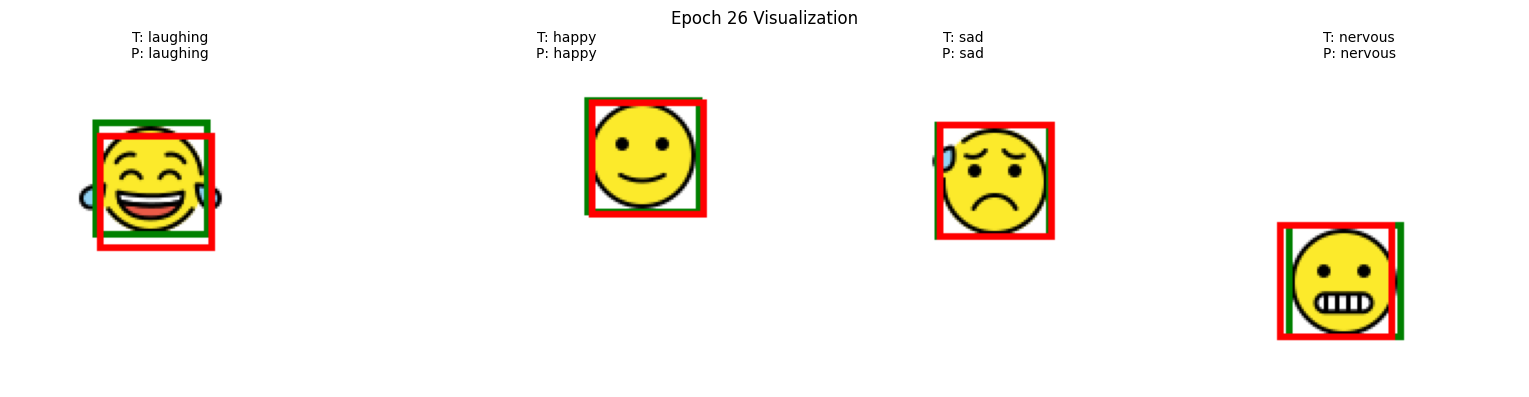

400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.7977e-05 - coord_output_iou: 0.9277 - coord_output_loss: 7.5797e-05 - loss: 1.0377e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.5248e-05 - val_coord_output_iou: 0.8525 - val_coord_output_loss: 3.7674e-04 - val_loss: 4.1199e-04 - learning_rate: 3.9063e-06
Epoch 27/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.7422e-05 - coord_output_iou: 0.9289 - coord_output_loss: 7.3425e-05 - loss: 1.0085e-04

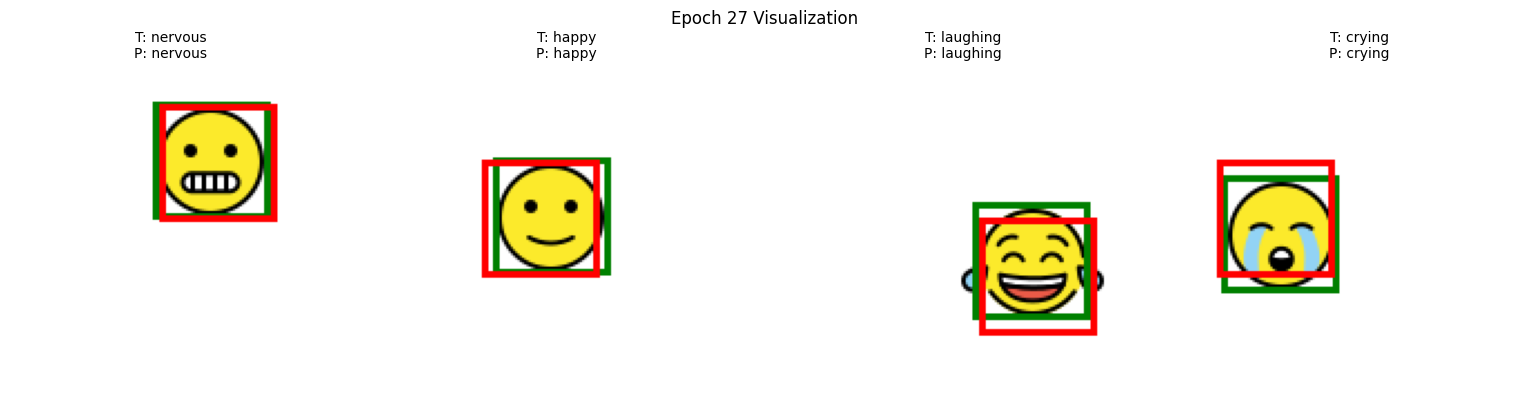

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.7419e-05 - coord_output_iou: 0.9289 - coord_output_loss: 7.3394e-05 - loss: 1.0081e-04 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.4945e-05 - val_coord_output_iou: 0.8527 - val_coord_output_loss: 3.7581e-04 - val_loss: 4.1075e-04 - learning_rate: 3.9063e-06
Epoch 28/50
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.6834e-05 - coord_output_iou: 0.9304 - coord_output_loss: 7.0274e-05 - loss: 9.7108e-05

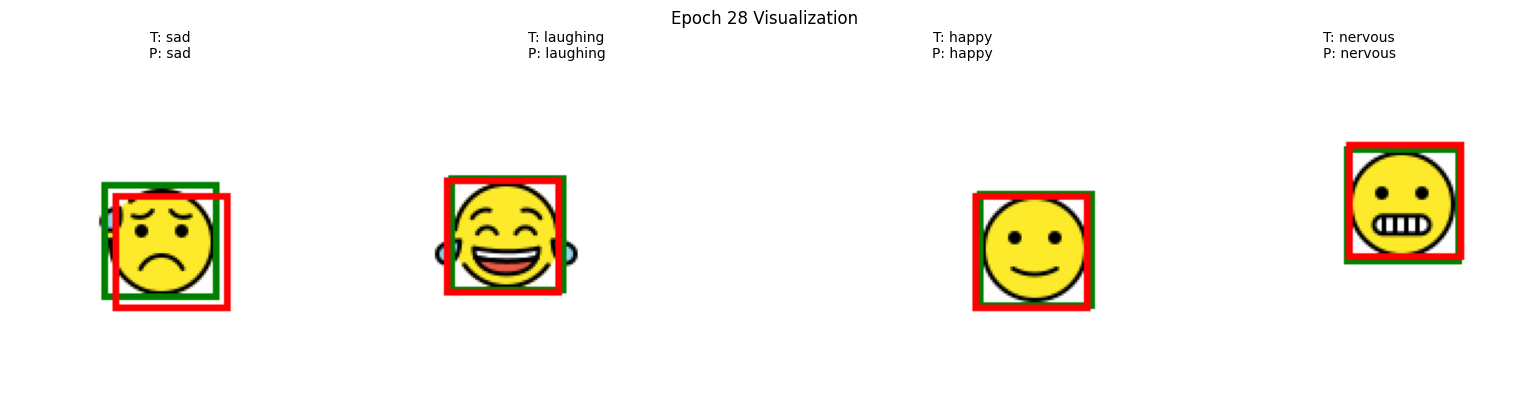


Epoch 28: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.6833e-05 - coord_output_iou: 0.9304 - coord_output_loss: 7.0260e-05 - loss: 9.7093e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.4447e-05 - val_coord_output_iou: 0.8528 - val_coord_output_loss: 3.7477e-04 - val_loss: 4.0922e-04 - learning_rate: 3.9063e-06
Epoch 29/50
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.6242e-05 - coord_output_iou: 0.9310 - coord_output_loss: 6.9059e-05 - loss: 9.5301e-05

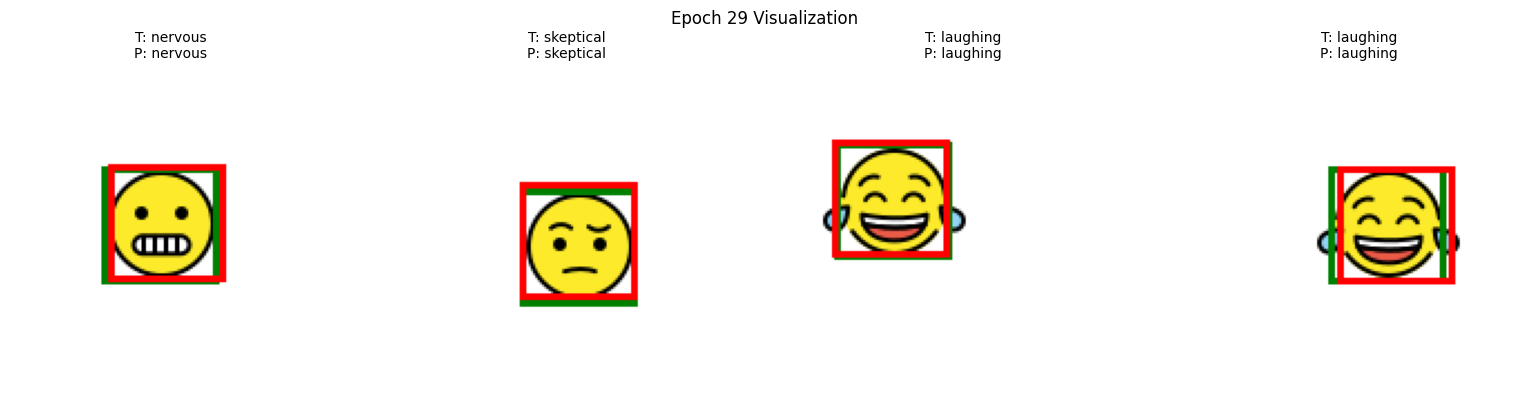

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.6240e-05 - coord_output_iou: 0.9310 - coord_output_loss: 6.9036e-05 - loss: 9.5277e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.3747e-05 - val_coord_output_iou: 0.8554 - val_coord_output_loss: 3.5707e-04 - val_loss: 3.9082e-04 - learning_rate: 1.9531e-06
Epoch 30/50
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.5871e-05 - coord_output_iou: 0.9327 - coord_output_loss: 6.5813e-05 - loss: 9.1684e-05

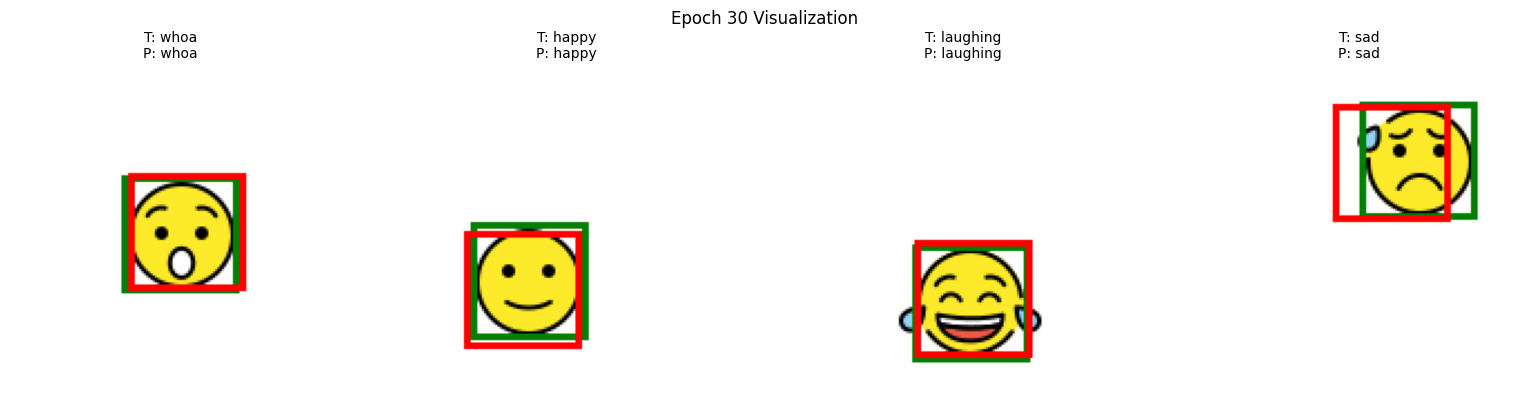

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.5870e-05 - coord_output_iou: 0.9327 - coord_output_loss: 6.5796e-05 - loss: 9.1666e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.3416e-05 - val_coord_output_iou: 0.8555 - val_coord_output_loss: 3.5714e-04 - val_loss: 3.9056e-04 - learning_rate: 1.9531e-06
Epoch 31/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.5479e-05 - coord_output_iou: 0.9337 - coord_output_loss: 6.3908e-05 - loss: 8.9386e-05

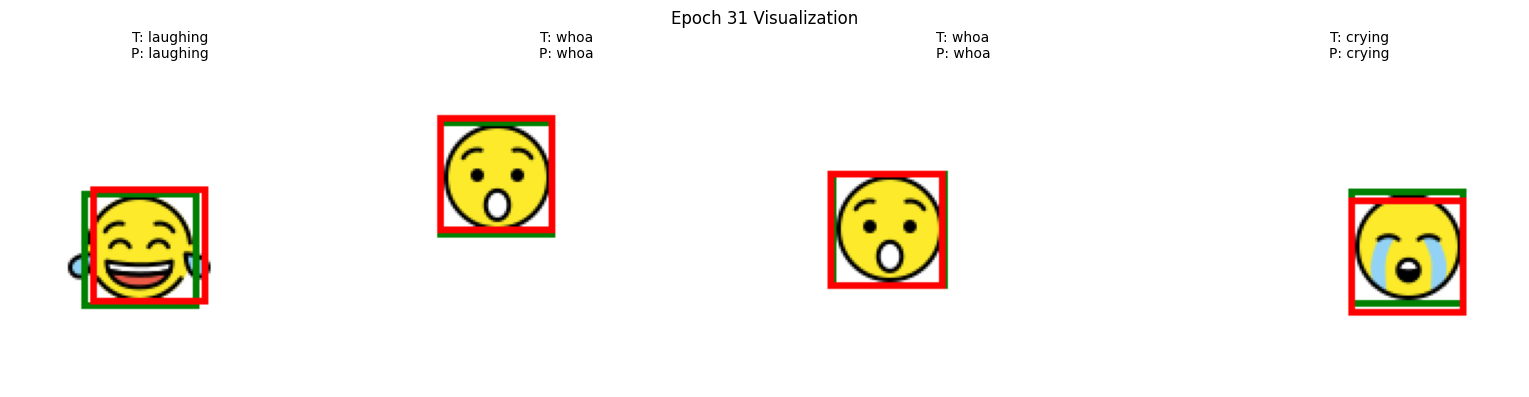


Epoch 31: ReduceLROnPlateau reducing learning rate to 1e-06.
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.5478e-05 - coord_output_iou: 0.9337 - coord_output_loss: 6.3900e-05 - loss: 8.9378e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.3059e-05 - val_coord_output_iou: 0.8554 - val_coord_output_loss: 3.5728e-04 - val_loss: 3.9034e-04 - learning_rate: 1.9531e-06
Epoch 32/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.5079e-05 - coord_output_iou: 0.9340 - coord_output_loss: 6.3232e-05 - loss: 8.8311e-05

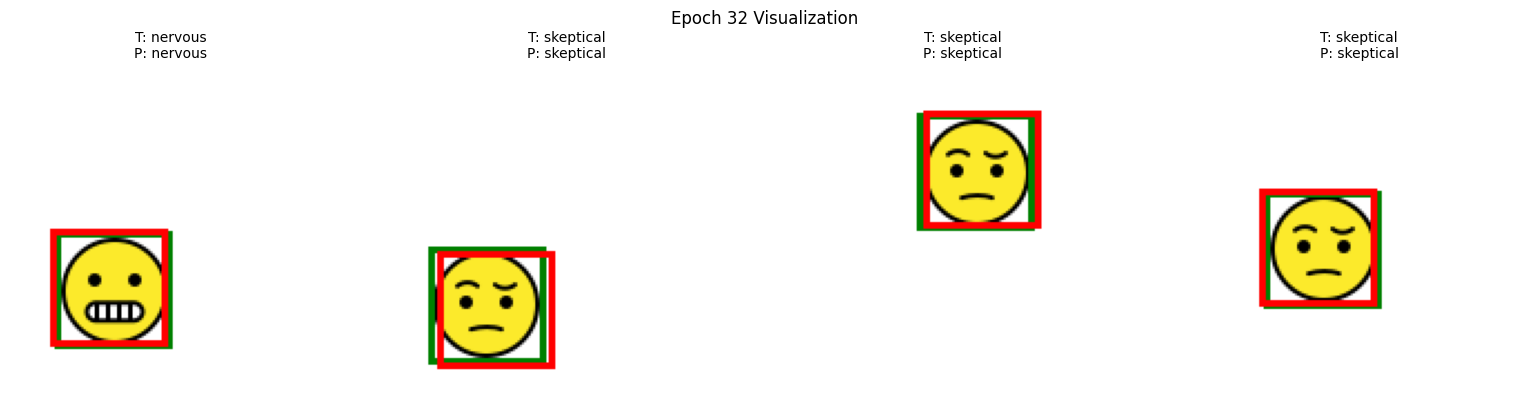

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.5078e-05 - coord_output_iou: 0.9340 - coord_output_loss: 6.3221e-05 - loss: 8.8299e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.2711e-05 - val_coord_output_iou: 0.8570 - val_coord_output_loss: 3.4804e-04 - val_loss: 3.8075e-04 - learning_rate: 1.0000e-06
Epoch 33/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.4838e-05 - coord_output_iou: 0.9352 - coord_output_loss: 6.0835e-05 - loss: 8.5673e-05

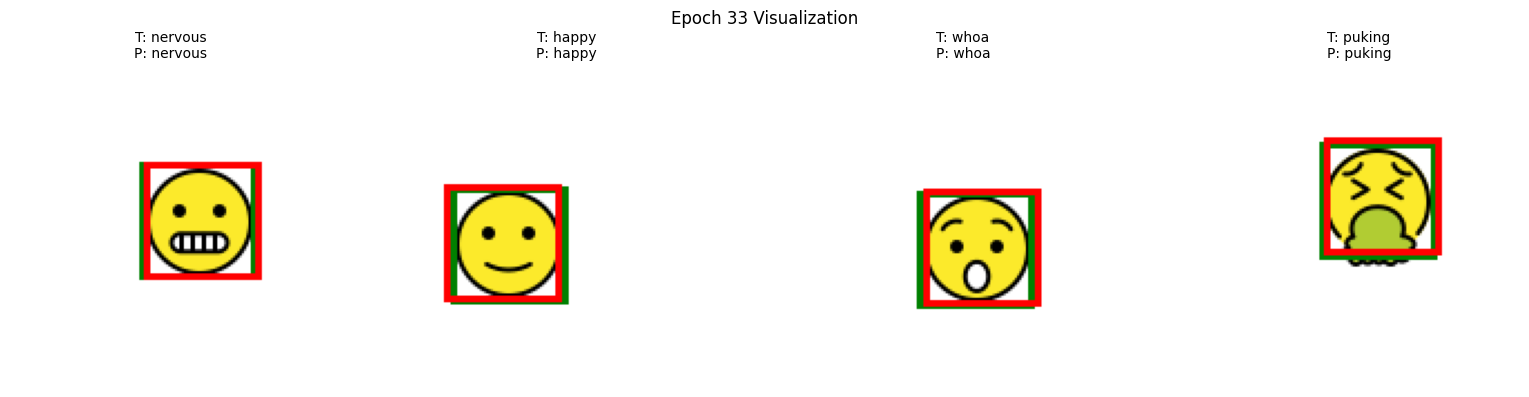

400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.4836e-05 - coord_output_iou: 0.9352 - coord_output_loss: 6.0801e-05 - loss: 8.5636e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.2451e-05 - val_coord_output_iou: 0.8571 - val_coord_output_loss: 3.4783e-04 - val_loss: 3.8028e-04 - learning_rate: 1.0000e-06
Epoch 34/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.4575e-05 - coord_output_iou: 0.9359 - coord_output_loss: 5.9640e-05 - loss: 8.4215e-05

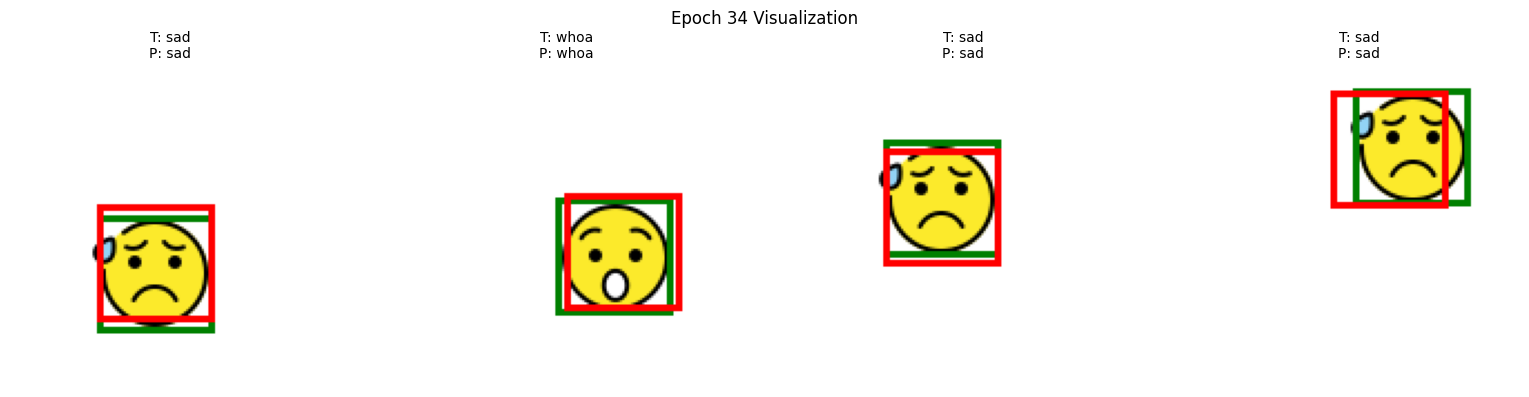

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.4573e-05 - coord_output_iou: 0.9359 - coord_output_loss: 5.9608e-05 - loss: 8.4181e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.2121e-05 - val_coord_output_iou: 0.8571 - val_coord_output_loss: 3.4768e-04 - val_loss: 3.7980e-04 - learning_rate: 1.0000e-06
Epoch 35/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.4295e-05 - coord_output_iou: 0.9365 - coord_output_loss: 5.8484e-05 - loss: 8.2779e-05

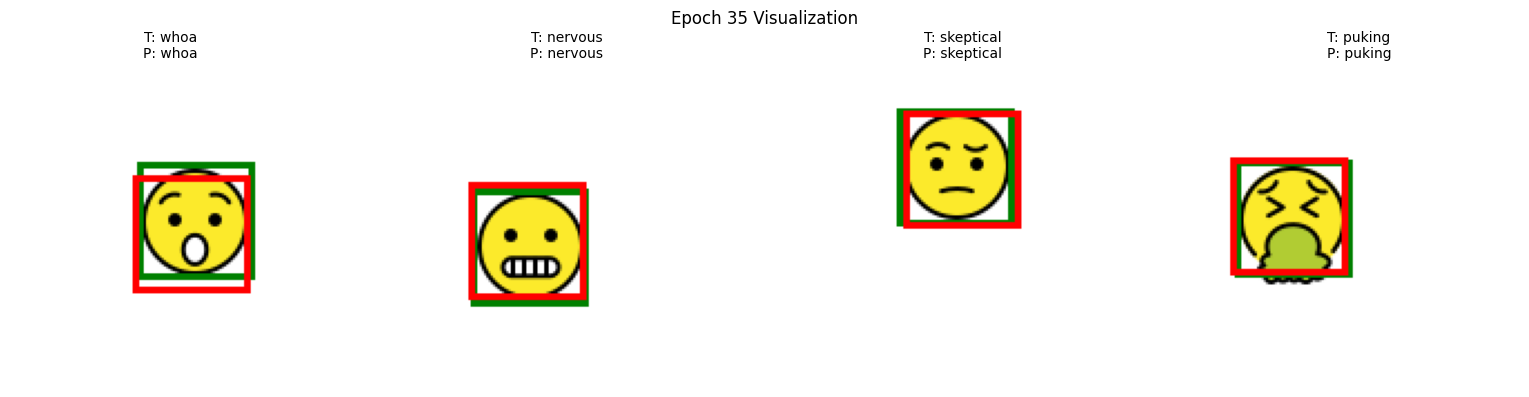

400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.4293e-05 - coord_output_iou: 0.9365 - coord_output_loss: 5.8453e-05 - loss: 8.2746e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.1828e-05 - val_coord_output_iou: 0.8571 - val_coord_output_loss: 3.4755e-04 - val_loss: 3.7938e-04 - learning_rate: 1.0000e-06
Epoch 36/50
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.3998e-05 - coord_output_iou: 0.9371 - coord_output_loss: 5.7333e-05 - loss: 8.1332e-05

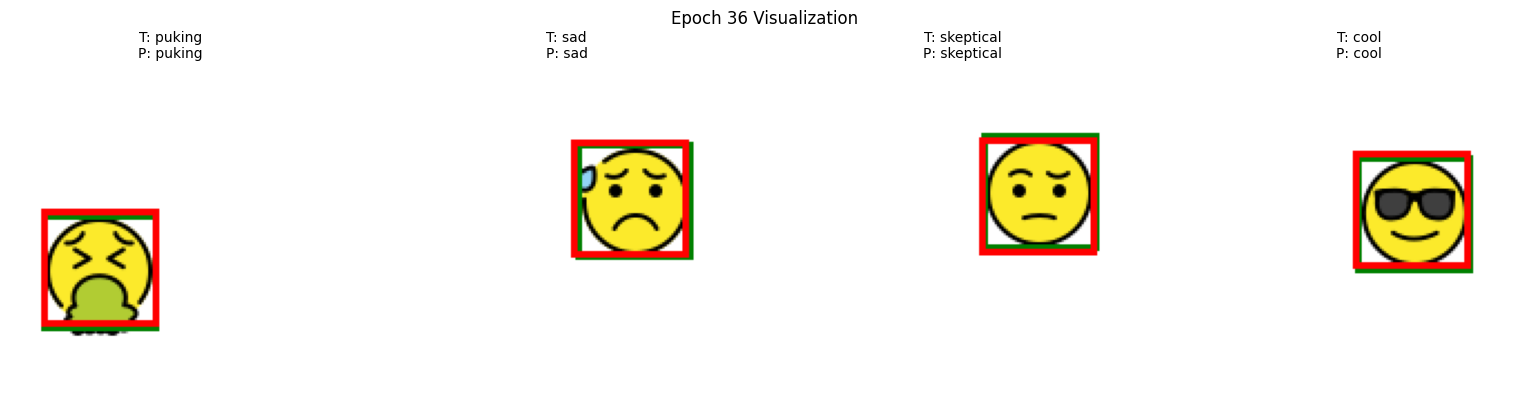

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.3997e-05 - coord_output_iou: 0.9371 - coord_output_loss: 5.7311e-05 - loss: 8.1307e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.1528e-05 - val_coord_output_iou: 0.8573 - val_coord_output_loss: 3.4705e-04 - val_loss: 3.7858e-04 - learning_rate: 1.0000e-06
Epoch 37/50
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.3688e-05 - coord_output_iou: 0.9377 - coord_output_loss: 5.6182e-05 - loss: 7.9870e-05

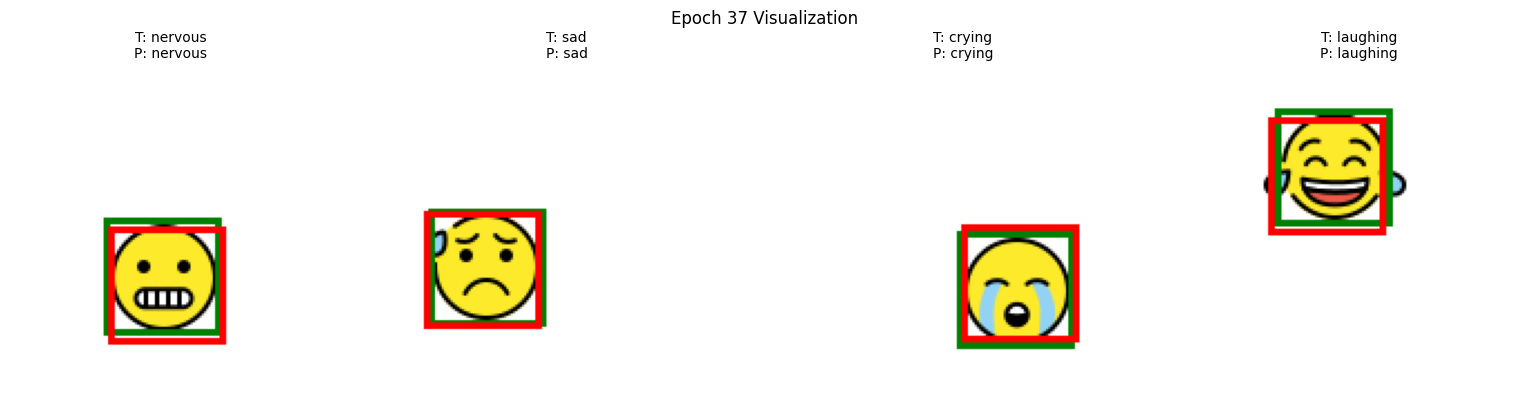

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.3687e-05 - coord_output_iou: 0.9378 - coord_output_loss: 5.6168e-05 - loss: 7.9855e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.1221e-05 - val_coord_output_iou: 0.8573 - val_coord_output_loss: 3.4689e-04 - val_loss: 3.7811e-04 - learning_rate: 1.0000e-06
Epoch 38/50
396/400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.3366e-05 - coord_output_iou: 0.9384 - coord_output_loss: 5.5077e-05 - loss: 7.8442e-05

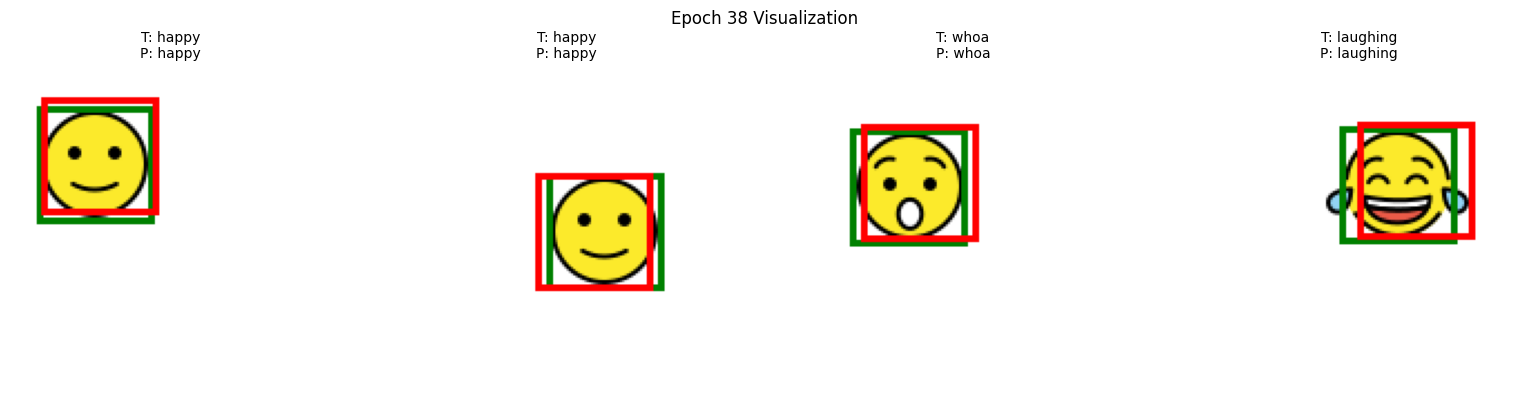

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.3363e-05 - coord_output_iou: 0.9384 - coord_output_loss: 5.5042e-05 - loss: 7.8405e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.0754e-05 - val_coord_output_iou: 0.8574 - val_coord_output_loss: 3.4650e-04 - val_loss: 3.7726e-04 - learning_rate: 1.0000e-06
Epoch 39/50
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.3031e-05 - coord_output_iou: 0.9390 - coord_output_loss: 5.3932e-05 - loss: 7.6963e-05

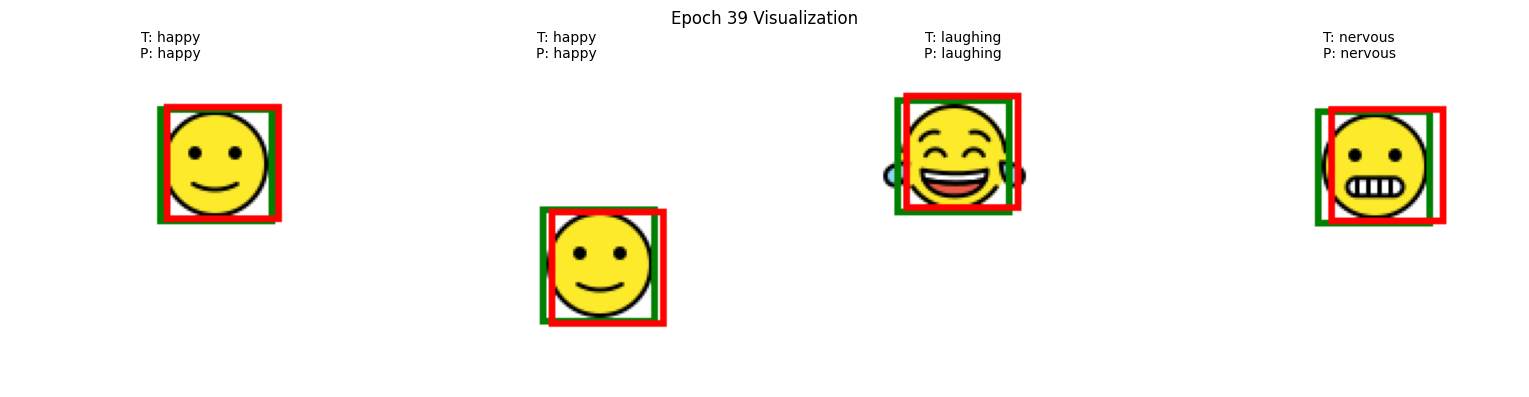

400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.3030e-05 - coord_output_iou: 0.9390 - coord_output_loss: 5.3912e-05 - loss: 7.6942e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.0494e-05 - val_coord_output_iou: 0.8575 - val_coord_output_loss: 3.4617e-04 - val_loss: 3.7667e-04 - learning_rate: 1.0000e-06
Epoch 40/50
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.2688e-05 - coord_output_iou: 0.9396 - coord_output_loss: 5.2825e-05 - loss: 7.5513e-05

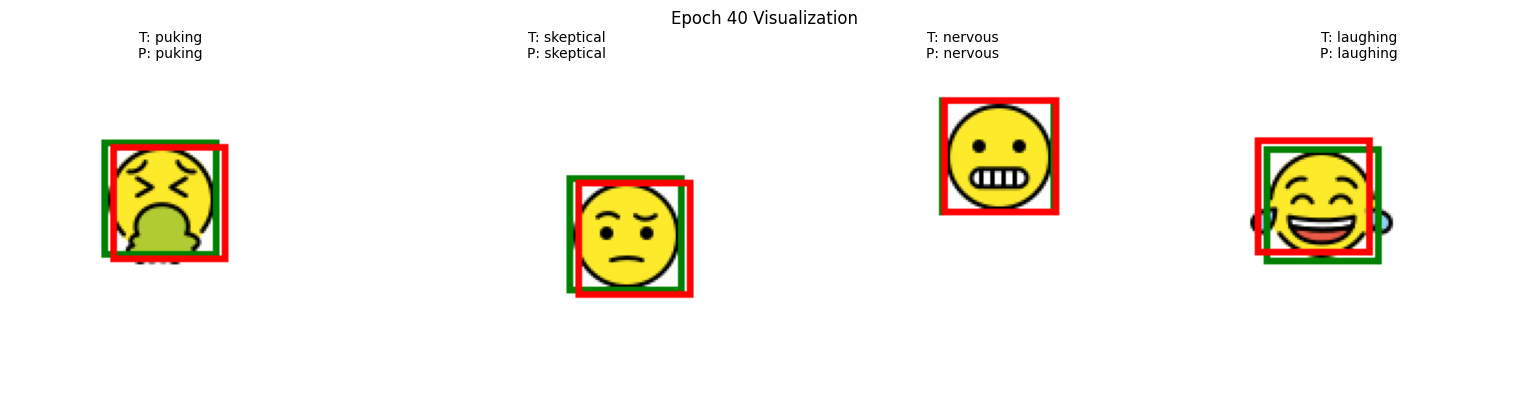

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.2687e-05 - coord_output_iou: 0.9397 - coord_output_loss: 5.2806e-05 - loss: 7.5493e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 3.0175e-05 - val_coord_output_iou: 0.8576 - val_coord_output_loss: 3.4583e-04 - val_loss: 3.7601e-04 - learning_rate: 1.0000e-06
Epoch 41/50
395/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.2343e-05 - coord_output_iou: 0.9403 - coord_output_loss: 5.1752e-05 - loss: 7.4095e-05

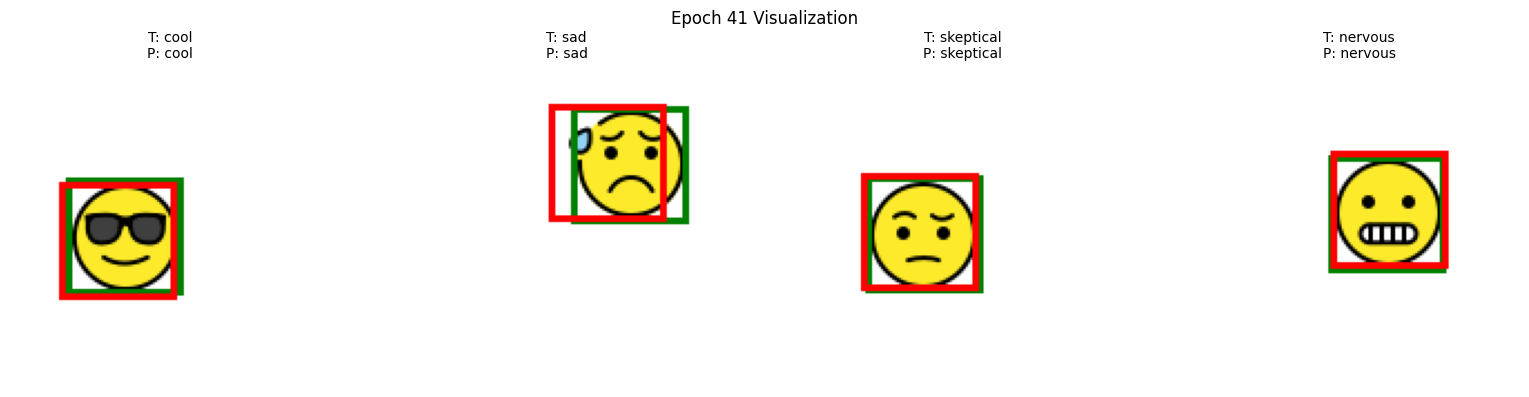

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.2340e-05 - coord_output_iou: 0.9403 - coord_output_loss: 5.1715e-05 - loss: 7.4055e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.9747e-05 - val_coord_output_iou: 0.8577 - val_coord_output_loss: 3.4542e-04 - val_loss: 3.7517e-04 - learning_rate: 1.0000e-06
Epoch 42/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.1991e-05 - coord_output_iou: 0.9409 - coord_output_loss: 5.0677e-05 - loss: 7.2668e-05

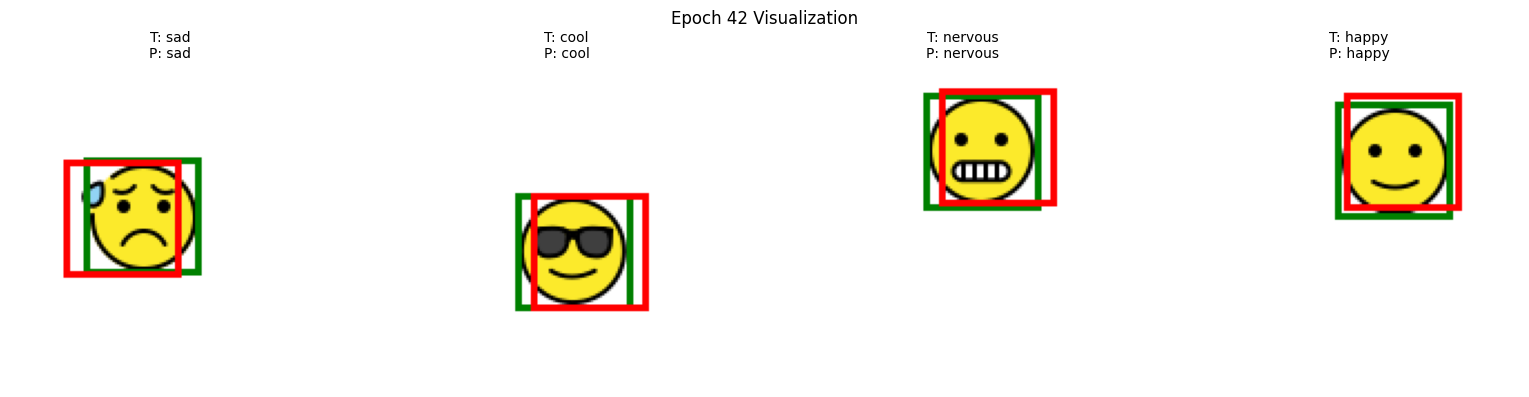

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.1989e-05 - coord_output_iou: 0.9409 - coord_output_loss: 5.0654e-05 - loss: 7.2642e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.9442e-05 - val_coord_output_iou: 0.8578 - val_coord_output_loss: 3.4509e-04 - val_loss: 3.7454e-04 - learning_rate: 1.0000e-06
Epoch 43/50
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.1640e-05 - coord_output_iou: 0.9415 - coord_output_loss: 4.9631e-05 - loss: 7.1271e-05

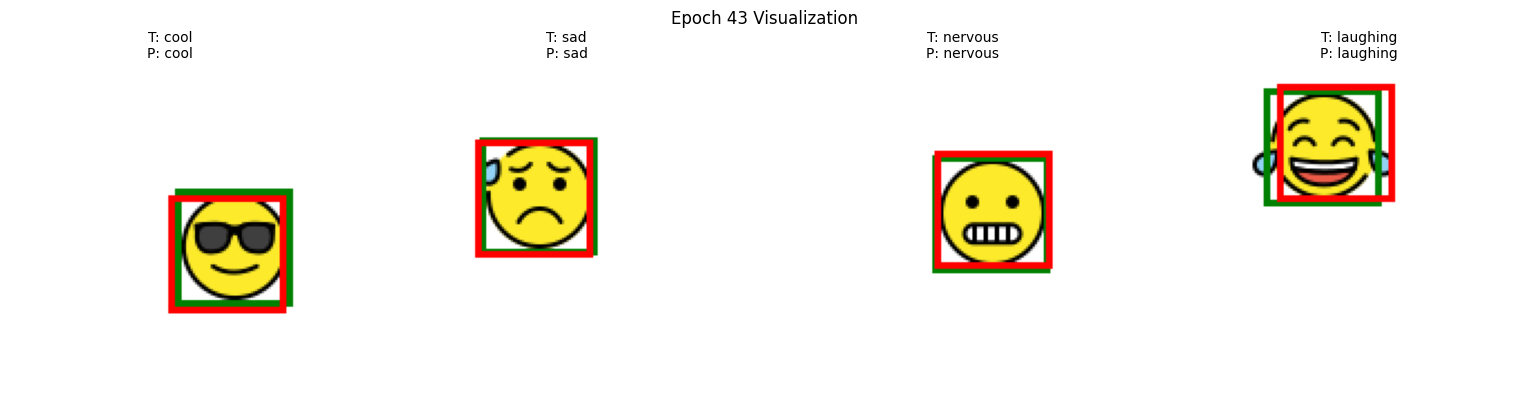

400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.1639e-05 - coord_output_iou: 0.9415 - coord_output_loss: 4.9614e-05 - loss: 7.1253e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.9069e-05 - val_coord_output_iou: 0.8579 - val_coord_output_loss: 3.4465e-04 - val_loss: 3.7372e-04 - learning_rate: 1.0000e-06
Epoch 44/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.1288e-05 - coord_output_iou: 0.9421 - coord_output_loss: 4.8598e-05 - loss: 6.9886e-05

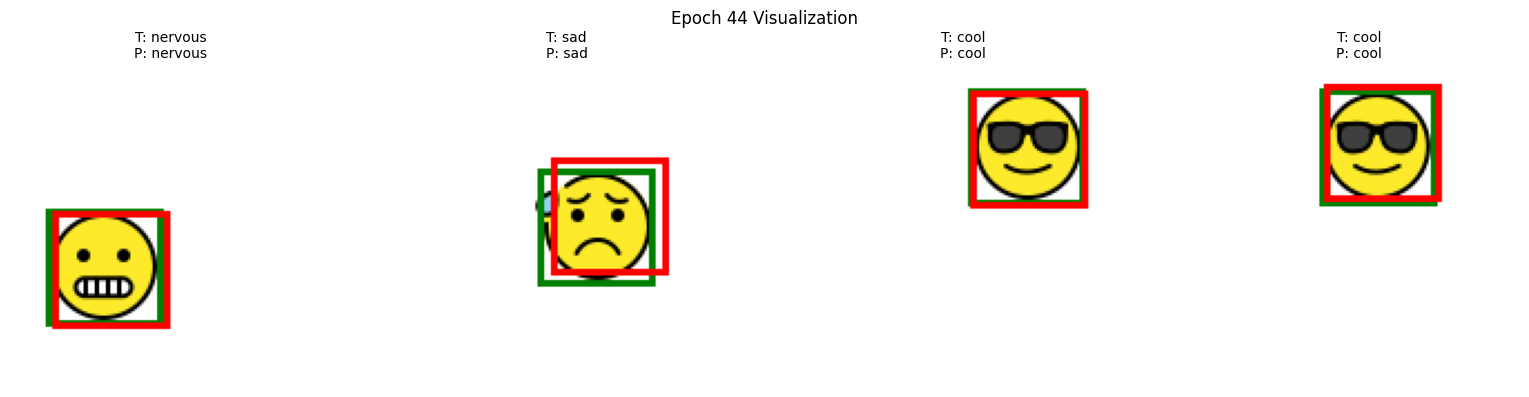

400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.1287e-05 - coord_output_iou: 0.9422 - coord_output_loss: 4.8593e-05 - loss: 6.9880e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.8744e-05 - val_coord_output_iou: 0.8580 - val_coord_output_loss: 3.4426e-04 - val_loss: 3.7300e-04 - learning_rate: 1.0000e-06
Epoch 45/50
396/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.0939e-05 - coord_output_iou: 0.9427 - coord_output_loss: 4.7620e-05 - loss: 6.8559e-05

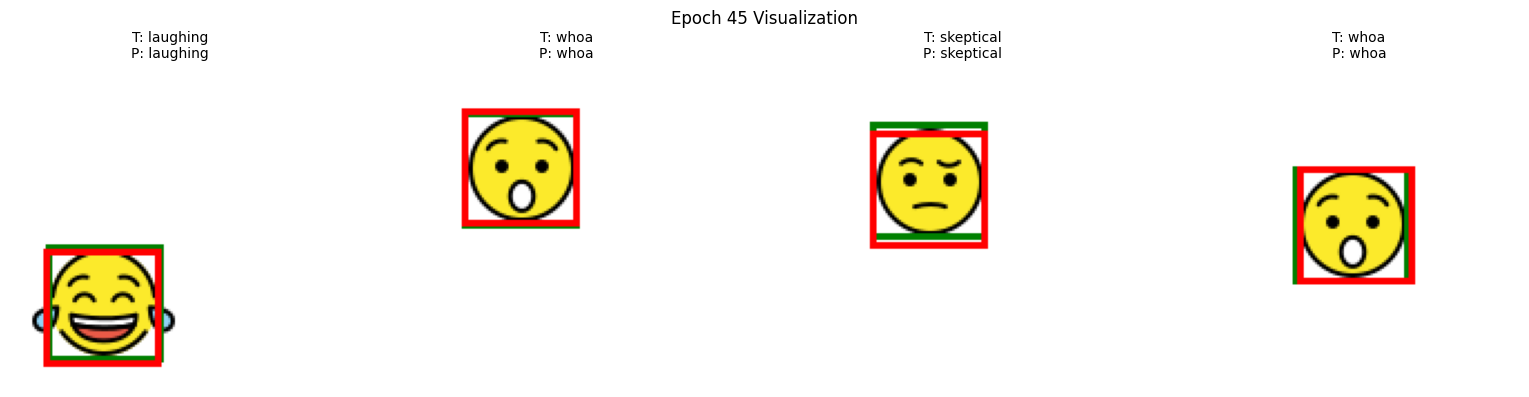

400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.0937e-05 - coord_output_iou: 0.9428 - coord_output_loss: 4.7593e-05 - loss: 6.8530e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.8354e-05 - val_coord_output_iou: 0.8580 - val_coord_output_loss: 3.4396e-04 - val_loss: 3.7231e-04 - learning_rate: 1.0000e-06
Epoch 46/50
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.0591e-05 - coord_output_iou: 0.9433 - coord_output_loss: 4.6631e-05 - loss: 6.7222e-05

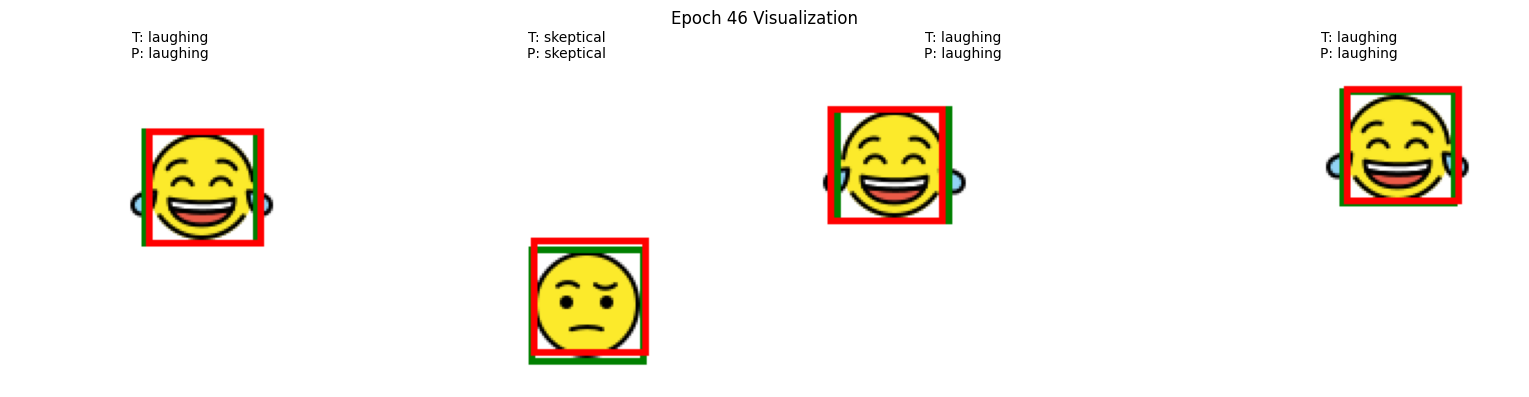

400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.0590e-05 - coord_output_iou: 0.9434 - coord_output_loss: 4.6621e-05 - loss: 6.7211e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.7980e-05 - val_coord_output_iou: 0.8581 - val_coord_output_loss: 3.4359e-04 - val_loss: 3.7157e-04 - learning_rate: 1.0000e-06
Epoch 47/50
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.0251e-05 - coord_output_iou: 0.9439 - coord_output_loss: 4.5677e-05 - loss: 6.5928e-05

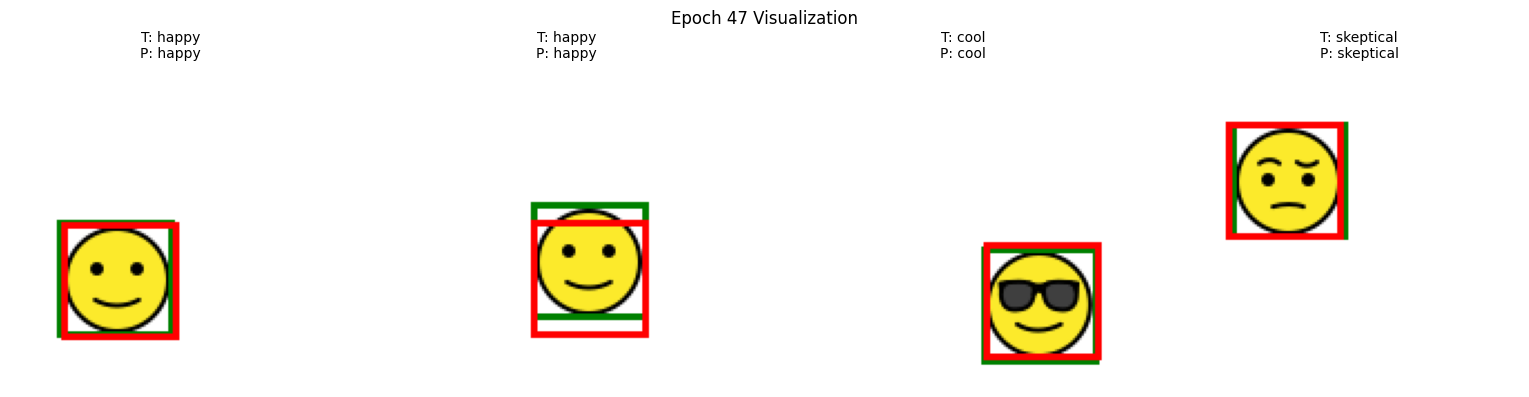

400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.0250e-05 - coord_output_iou: 0.9440 - coord_output_loss: 4.5662e-05 - loss: 6.5912e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.7638e-05 - val_coord_output_iou: 0.8582 - val_coord_output_loss: 3.4313e-04 - val_loss: 3.7077e-04 - learning_rate: 1.0000e-06
Epoch 48/50
397/400 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.9916e-05 - coord_output_iou: 0.9445 - coord_output_loss: 4.4743e-05 - loss: 6.4659e-05

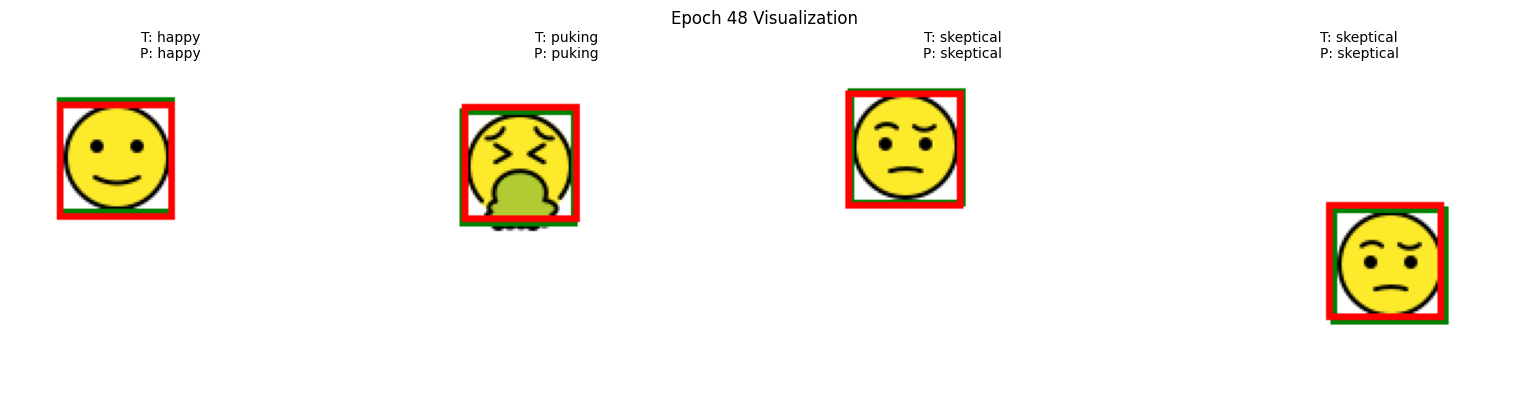

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.9914e-05 - coord_output_iou: 0.9445 - coord_output_loss: 4.4724e-05 - loss: 6.4638e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.7313e-05 - val_coord_output_iou: 0.8583 - val_coord_output_loss: 3.4280e-04 - val_loss: 3.7012e-04 - learning_rate: 1.0000e-06
Epoch 49/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.9586e-05 - coord_output_iou: 0.9451 - coord_output_loss: 4.3819e-05 - loss: 6.3406e-05

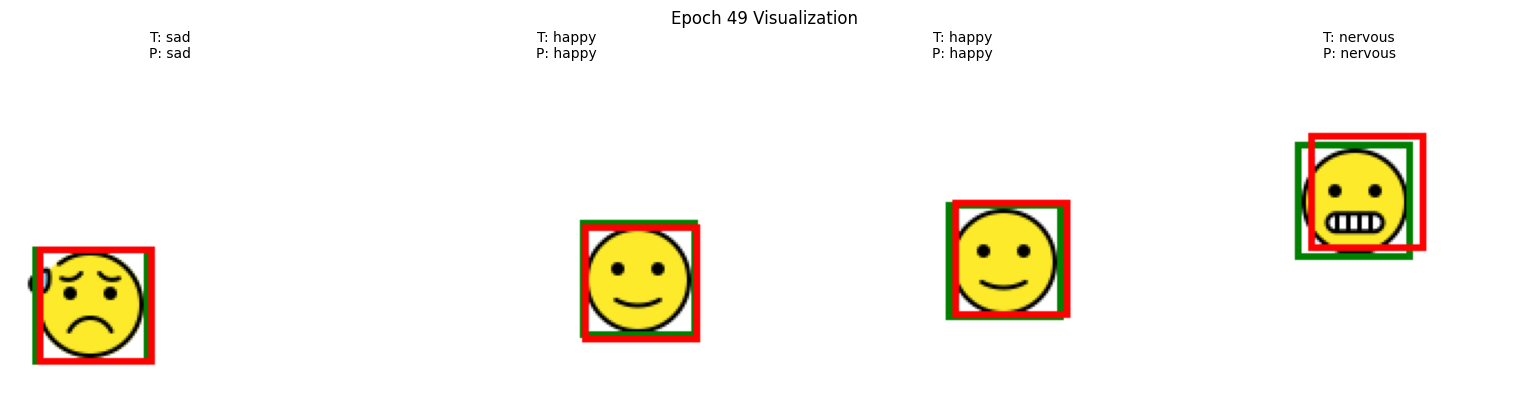

400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.9586e-05 - coord_output_iou: 0.9451 - coord_output_loss: 4.3815e-05 - loss: 6.3401e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.6972e-05 - val_coord_output_iou: 0.8582 - val_coord_output_loss: 3.4285e-04 - val_loss: 3.6982e-04 - learning_rate: 1.0000e-06
Epoch 50/50
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.9259e-05 - coord_output_iou: 0.9457 - coord_output_loss: 4.2938e-05 - loss: 6.2196e-05

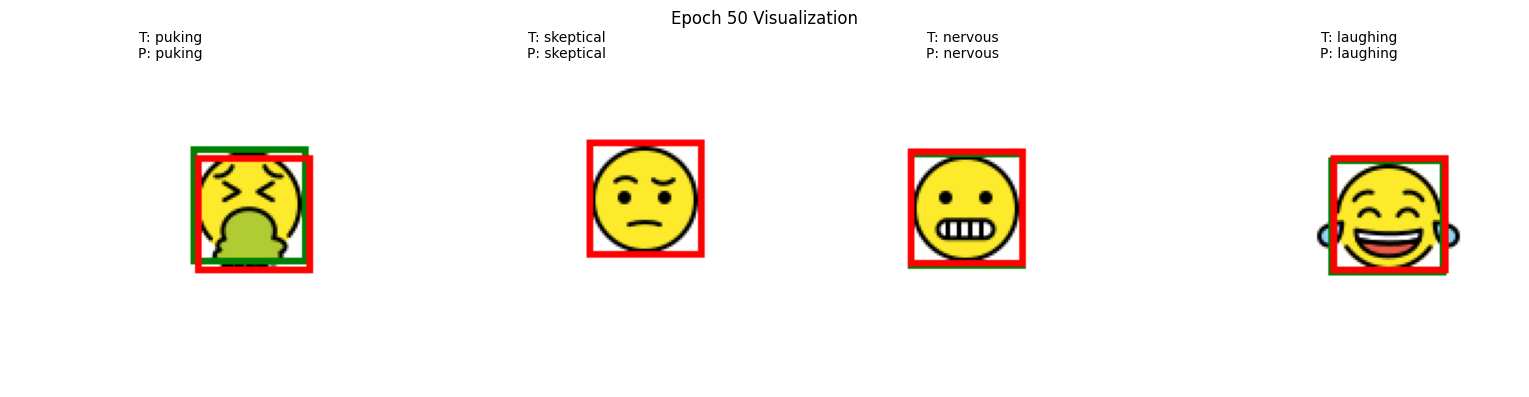

400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.9258e-05 - coord_output_iou: 0.9457 - coord_output_loss: 4.2929e-05 - loss: 6.2187e-05 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.6615e-05 - val_coord_output_iou: 0.8584 - val_coord_output_loss: 3.4231e-04 - val_loss: 3.6893e-04 - learning_rate: 1.0000e-06
Restoring model weights from the end of the best epoch: 50.


In [ ]:
history = model.fit(
    x_train,
    {'class_output': y_train_class, 'coord_output': y_train_coord},
    epochs=50,
    batch_size=16,
    validation_data=(x_test, {'class_output': y_test_class, 'coord_output': y_test_coord}),
    callbacks=[vis_callback, reduce_lr, early_stop]  # Add visualization callback
)

##  Visualize Results

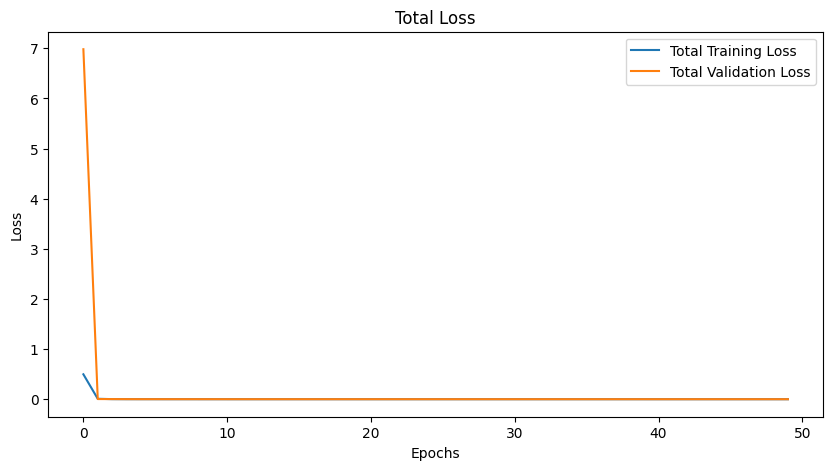

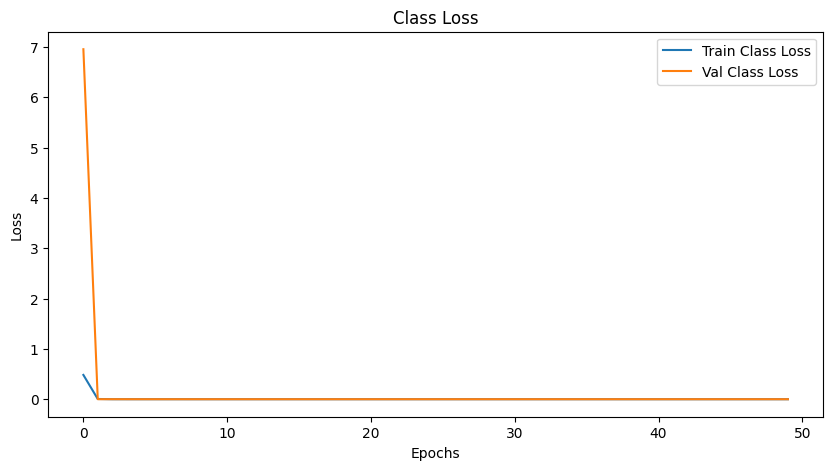

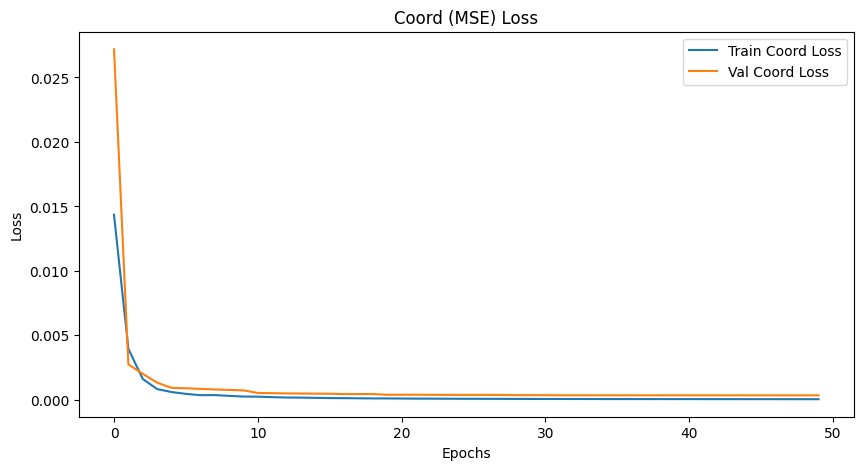

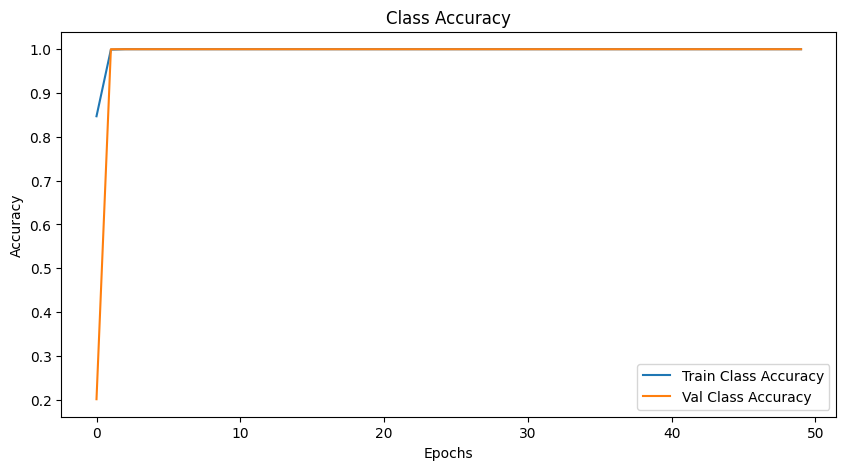

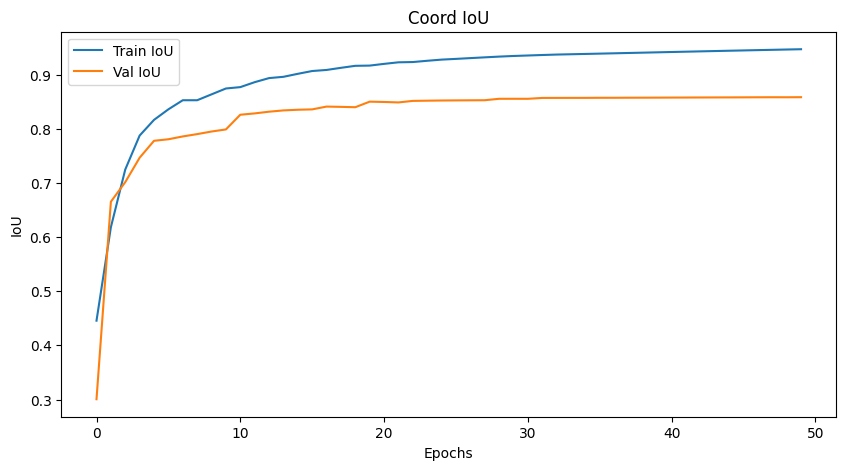

Test Total Loss: 0.00036892545176669955
Test Class Loss: 2.6615376555128023e-05
Test Coord Loss (MSE): 0.0003423100570216775
Test Class Accuracy: 1.0
Test Coord IoU: 0.8584045171737671
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step


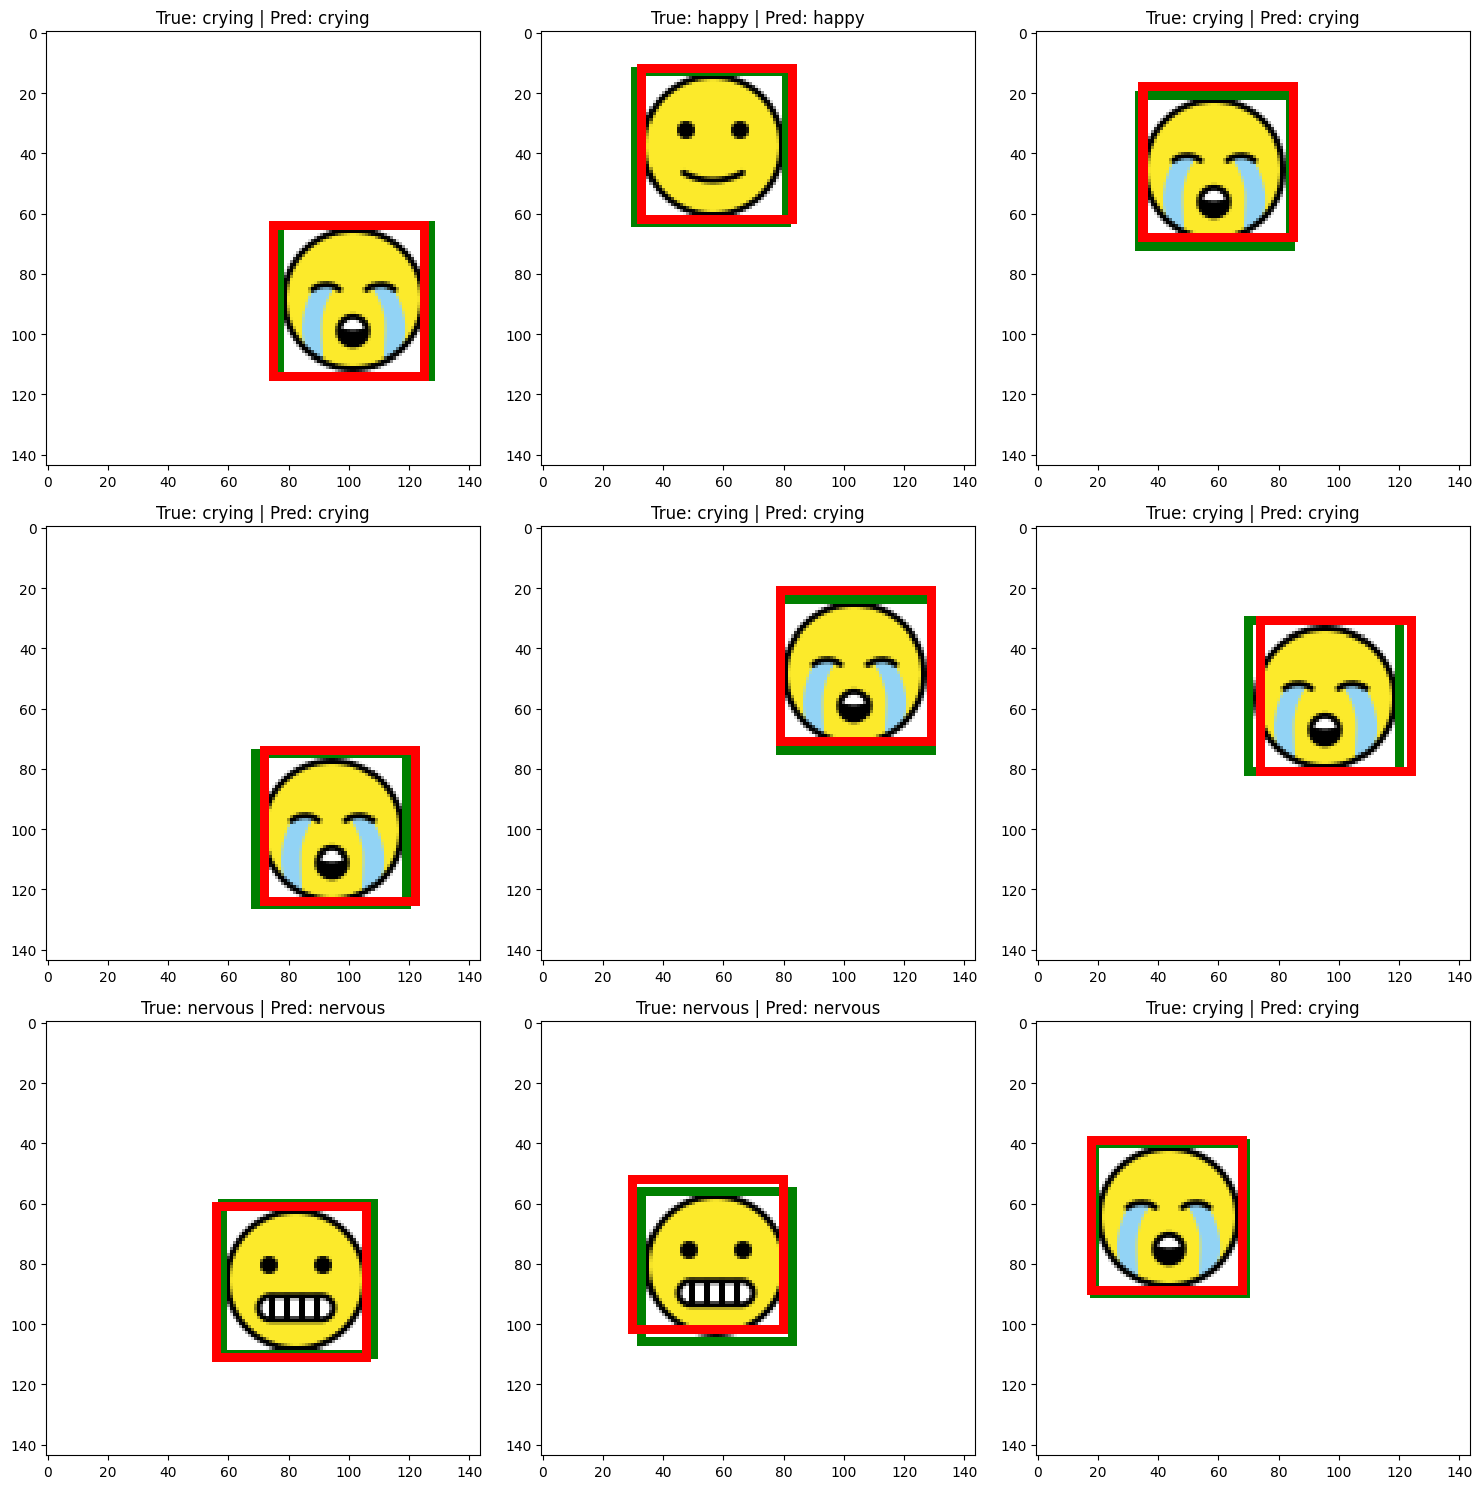

In [ ]:
#--------------------------------------------------------------
# Visualize Training Results
#--------------------------------------------------------------
# Extract data stored in history
history_dict = history.history

# Visualize total Loss
plt.figure(figsize=(10, 5))
plt.plot(history_dict['loss'], label='Total Training Loss')
plt.plot(history_dict['val_loss'], label='Total Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Classification output loss
plt.figure(figsize=(10,5))
plt.plot(history_dict['class_output_loss'], label='Train Class Loss')
plt.plot(history_dict['val_class_output_loss'], label='Val Class Loss')
plt.title('Class Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Coordinate output loss (MSE)
plt.figure(figsize=(10,5))
plt.plot(history_dict['coord_output_loss'], label='Train Coord Loss')
plt.plot(history_dict['val_coord_output_loss'], label='Val Coord Loss')
plt.title('Coord (MSE) Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Classification accuracy
plt.figure(figsize=(10,5))
plt.plot(history_dict['class_output_accuracy'], label='Train Class Accuracy')
plt.plot(history_dict['val_class_output_accuracy'], label='Val Class Accuracy')
plt.title('Class Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# IoU metric for coordinate regression
plt.figure(figsize=(10,5))
plt.plot(history_dict['coord_output_iou'], label='Train IoU')
plt.plot(history_dict['val_coord_output_iou'], label='Val IoU')
plt.title('Coord IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

#--------------------------------------------------------------
# Model Evaluation
#--------------------------------------------------------------
test_loss, test_class_loss, test_coord_loss, test_class_acc, test_coord_iou = model.evaluate(
    x_test,
    {'class_output': y_test_class, 'coord_output': y_test_coord},
    verbose=0
)
print("Test Total Loss:", test_loss)
print("Test Class Loss:", test_class_loss)
print("Test Coord Loss (MSE):", test_coord_loss)
print("Test Class Accuracy:", test_class_acc)
print("Test Coord IoU:", test_coord_iou)

#--------------------------------------------------------------
# Visualize Prediction Results
#--------------------------------------------------------------
# Randomly select some samples from the test set for prediction
num_visualize = 9
indices = np.random.choice(len(x_test), num_visualize, replace=False)
test_images_sample = x_test[indices]
test_class_sample = y_test_class[indices]
test_coord_sample = y_test_coord[indices]

pred_class_probs, pred_coords = model.predict(test_images_sample)

plt.figure(figsize=(15, 15))
for i in range(num_visualize):
    # Retrieve one test image (float in [0,1])
    img = test_images_sample[i].copy()
    # Convert predicted results to class IDs
    pred_class_id = np.argmax(pred_class_probs[i])
    # Get the true class ID
    true_class_id = np.argmax(test_class_sample[i])

    # Get the true and predicted coordinates
    true_coord = test_coord_sample[i]
    pred_coord = pred_coords[i]

    # Convert the image from [0,1] to [0,255] and then to uint8
    img_uint8 = (img * 255.).astype(np.uint8)

    # Draw both the true and predicted bounding boxes
    img_with_boxes = plot_bounding_box(img_uint8, gt_coords=true_coord, pred_coords=pred_coord, norm=False)

    plt.subplot(3, 3, i+1)
    plt.imshow(img_with_boxes)
    plt.title(f"True: {emojis[true_class_id]['name']} | Pred: {emojis[pred_class_id]['name']}")

plt.tight_layout()
plt.show()